# IQNx4: 1. Setup and Preprocess

# Do `source setup.sh` before trying to run this notebook!

## External Imports

If you don't have some of these packages installed, you can also use the conda environment that has all of the packages by doing `conda env create -f IQN_env.yml && conda activate IQN_env`

There is a live executable version of this notebook on binder, just click this link : [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/AliAlkadhim/torchQN/HEAD?labpath=JupyterBook)

Note that the binder will take a while to build, and you'd have to navigate through the files yourself (not as easy or nice as just going to https://alialkadhim.github.io/torchQN/)

### If you want to run this interactively on binder, set `BINDER=True`. This will download our datasets using the Kaggle API. Our datasets are simply the following:

In [1]:
BINDER=False
if BINDER:
    import kaggle
    from kaggle.api.kaggle_api_extended import KaggleApi
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files('

In [2]:
import numpy as np; import pandas as pd
# import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn; print(f"using torch version {torch.__version__}")
#use numba's just-in-time compiler to speed things up
# from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; print('matplotlib version= ', mp.__version__)

import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
#reset matplotlib parameters to their defaults
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
font_legend = 15; font_axes=15
# %matplotlib inline
import sys; import os
from IPython.display import Image, display
# from importlib import import_module
import plotly
try:
    import optuna
    print(f"using (optional) optuna version {optuna.__version__}")
except Exception:
    print('optuna is only used for hyperparameter tuning, not critical!')
    pass
import argparse
import time
# import sympy as sy
import ipywidgets as wid; 


using torch version 1.9.0
matplotlib version=  3.5.1
using (optional) optuna version 2.8.0


print the versions of the packages

In [1]:
%load_ext watermark

%watermark -v -m -p numpy,pandas,torch,scikit-learn,matplotlib,os,IPython,kaggle,plotly,optuna,argparse,time,ipywidgets

print(" ")
%watermark -u -n -t -z

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.31.1

numpy       : 1.21.5
pandas      : 1.3.5
torch       : 1.9.0
scikit-learn: 1.0.2
matplotlib  : 3.5.1
os          : unknown
IPython     : None
opendatasets: not installed
plotly      : 5.11.0
optuna      : 2.8.0
argparse    : 1.1
time        : unknown
ipywidgets  : 7.6.5

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.4.0-135-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

 
Last updated: Fri Dec 30 2022 19:40:01EST



## Import utils, and set environemnt variables

need to tune latest braden scaling hyperparameters on cluster.

see if i can find/write a decorator to add the current cell to a file which will be run on cluster. I think %writefile file.py could work, by adding the cell to another file... 


In [2]:
# 'IQN' in 
# some_environment={}
# some_environment.update(os.environ())
# some_environment
# 'DATA' in list(os.environ)

In [3]:
# os.environ['IQN_BASE']='/home/ali/Desktop/Pulled_Github_Repositories/torchQN'
# os.environ['DATA_DIR']='/home/DAVIDSON/alalkadhim.visitor/IQN/DAVIDSON_NEW/data'

### A user is competent enought to do `source setup.sh` on a `setup.sh` script that comes in the repo, such as the next cell uncommented

In [4]:
# #!/bin/bash
# export IQN_BASE= $pwd #/home/ali/Desktop/Pulled_Github_Repositories/torchQN

# #DAVIDSON
# export DATA_DIR='/home/DAVIDSON/alalkadhim.visitor/IQN/DAVIDSON_NEW/data'
# #LOCAL
# export DATA_DIR='/home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data'
# echo DATA DIR
# ls -l $DATA_DIR
# #ln -s $DATA_DIR $IQN_BASE, if you want
# #conda create env -n torch_env -f torch_env.yml
# conda activate torch_env
# mkdir -p ${IQN_BASE}/images/loss_plots ${IQN_BASE}/trained_models  ${IQN_BASE}/hyperparameters ${IQN_BASE}/predicted_data
# tree $IQN_BASE

In [3]:
# env = {}
# env.update(os.environ)
# env.update(source(os.environ["IQN_BASE"])) 

try:
    IQN_BASE = os.environ['IQN_BASE']
    print('BASE directoy properly set = ', IQN_BASE)
    utils_dir = os.path.join(IQN_BASE, 'utils/')
    sys.path.append(utils_dir)
    import utils
    #usually its not recommended to import everything from a module, but we know
    #whats in it so its fine
    from utils import *
    print('DATA directory also properly set, in %s' % os.environ['DATA_DIR'])
except Exception:
    # IQN_BASE=os.getcwd()
    print("""\nBASE directory not properly set. Read repo README.\
    If you need a function from utils, use the decorator below, or add utils to sys.path\n
    You can also do 
    os.environ['IQN_BASE']=<ABSOLUTE PATH FOR THE IQN REPO>
    or
    os.environ['IQN_BASE']=os.getcwd()""")
    pass

BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/torchQN
using torch version 1.9.0
matplotlib version=  3.5.1
using (optional) optuna version 2.8.0
BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/torchQN
DATA directory also properly set, in /home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data
DATA directory also properly set, in /home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data


In [6]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)
#sometimes jupyter doesnt initialize MathJax automatically for latex, so do this:
wid.HTMLMath('$\LaTeX$')

HTMLMath(value='$\\LaTeX$')

# 2. utils.py

In [5]:
import numpy as np; import pandas as pd
# import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn; print(f"using torch version {torch.__version__}")
#use numba's just-in-time compiler to speed things up
# from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; print('matplotlib version= ', mp.__version__)

import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
#reset matplotlib parameters to their defaults
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
font_legend = 15; font_axes=15
# %matplotlib inline
import sys; import os
# from IPython.display import Image, display
# from importlib import import_module
#import plotly
try:
    import optuna
    print(f"using (optional) optuna version {optuna.__version__}")
except Exception:
    print('optuna is only used for hyperparameter tuning, not critical!')
    pass
import argparse
import time
# import sympy as sy
#import ipywidgets as wid; 


try:
    IQN_BASE = os.environ['IQN_BASE']
    print('BASE directoy properly set = ', IQN_BASE)
    utils_dir = os.path.join(IQN_BASE, 'utils')
    sys.path.append(utils_dir)
    import utils
    #usually its not recommended to import everything from a module, but we know
    #whats in it so its fine
    from utils import *
    print('DATA directory also properly set, in %s' % os.environ['DATA_DIR'])
except Exception:
    # IQN_BASE=os.getcwd()
    print("""\nBASE directory not properly set. Read repo README.    If you need a function from utils, use the decorator below, or add utils to sys.path\n
    You can also do 
    os.environ['IQN_BASE']=<ABSOLUTE PATH FOR THE IQN REPO>
    or
    os.environ['IQN_BASE']=os.getcwd()""")
    pass


# device = torch.device("cuda:0")

# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

####################################################################



# class CustomDataset(Dataset):
#     """This takes the index for the data and target and gives dictionary of tensors of data and targets.
#     For example we could do train_dataset = CustomDataset(train_data, train_targets); test_dataset = CustomDataset(test_data, test_targets)
#  where train and test_dataset are np arrays that are reshaped to (-1,1).
#  Then train_dataset[0] gives a dictionary of samples "X" and targets"""
#     def __init__(self, data, targets):
#         self.data = data
#         self.targets=targets
#     def __len__(self):
#         return self.data.shape[0]
    
#     def __getitem__(self, idx):
        
#         current_sample = self.data[idx, :]
#         current_target = self.targets[idx]
#         return {"x": torch.tensor(current_sample, dtype = torch.float),
#                "y": torch.tensor(current_target, dtype= torch.float),
#                }#this already makes the targets made of one tensor (of one value) each


class RegressionModel(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                # layers.append(nn.Dropout(dropout))
                #ReLU activation 
                # layers.append(nn.ReLU())
                layers.append(nn.LeakyReLU())
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                # layers.append(nn.Dropout(dropout))
                # layers.append(nn.ReLU())
                layers.append(nn.LeakyReLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 
        
        # ONLY IF ITS A CLASSIFICATION, ADD SIGMOID
        #layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)
            
    
    def forward(self, x):
        return self.model(x)




class RegressionEngine:
    """loss, training and evaluation"""
    def __init__(self, model, optimizer):
                 #, device):
        self.model = model
        #self.device= device
        self.optimizer = optimizer
        
    #the loss function returns the loss function. It is a static method so it doesn't need self
    @staticmethod
    def quadratic_loss(targets, outputs):
         return nn.MSELoss()(outputs, targets)

    @staticmethod
    def average_quadratic_loss(targets, outputs):
    # f and t must be of the same shape
        return  torch.mean((outputs - targets)**2)
    
    @staticmethod
    def average_absolute_error(targets, outputs):
    # f and t must be of the same shape
        return  torch.mean(abs(outputs - targets))
    
    
    @staticmethod
    def average_cross_entropy_loss(targets, outputs):
        # f and t must be of the same shape
        loss = torch.where(targets > 0.5, torch.log(outputs), torch.log(1 - outputs))
        # the above means loss = log outputs, if target>0.5, and log(1-output) otherwise
        return -torch.mean(loss)
    
    @staticmethod
    def average_quantile_loss(targets, outputs):
        # f and t must be of the same shape
        tau = torch.rand(outputs.shape)
        #L= tau * (target - output), if target>output
        #L= (1-tau)*(output-target), otherwise
        return torch.mean(torch.where(targets > outputs, 
                                      tau * (targets - outputs), 
                                      (1 - tau)*(outputs - targets)))


    def train(self, data_loader):
        """the training function: takes the training dataloader"""
        self.model.train()
        final_loss = 0
        for data in data_loader:
            self.optimizer.zero_grad()#only optimize weights for the current batch, otherwise it's meaningless!
            inputs = data["x"]
            targets = data["y"]
            outputs = self.model(inputs)
            loss = self.average_quantile_loss(targets, outputs)
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()
        return final_loss / len(data_loader)

    
    def evaluate(self, data_loader):
        """the training function: takes the training dataloader"""
        self.model.eval()
        final_loss = 0
        for data in data_loader:
            inputs = data["x"]#.to(self.device)
            targets = data["y"]#.to(self.device)
            outputs = self.model(inputs)
            loss = self.average_quantile_loss(targets, outputs)
            final_loss += loss.item()
        return final_loss / len(data_loader)



class ModelHandler:
    def __init__(self, model, scalers):
        self.model  = model
        self.scaler_t, self.scaler_x = scalers
        
        self.scale  = self.scaler_t.scale_[0] # for output
        self.mean   = self.scaler_t.mean_[0]  # for output
        self.fields = self.scaler_x.feature_names_in_
        
    def __call__(self, df):
        
        # scale input data
        x  = np.array(self.scaler_x.transform(df[self.fields]))
        x  = torch.Tensor(x)

        # go to evaluation mode
        self.model.eval()
    
        # compute,reshape to a 1d array, and convert to a numpy array
        Y  = self.model(x).view(-1, ).detach().numpy()
        
        # rescale output
        Y  = self.mean + self.scale * Y
        
        if len(Y) == 1:
            return Y[0]
        else:
            return Y
        
    def show(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                print(name, param.data)
                print()


N_CNN_KERNEL=2
NFEATURES=1#train_x.shape[1]
N_MULT_FACTOR=2
N_HIDDEN=NFEATURES * N_MULT_FACTOR

class CNN_MODEL(nn.Module):    
    def __init__(self, n_feature, n_hidden, n_output, n_cnn_kernel, n_mult_factor=N_MULT_FACTOR):
        super(CNN_MODEL, self).__init__()
        self.n_feature=n_feature
        self.n_hidden=n_hidden
        self.n_output= n_output 
        self.n_cnn_kernel=n_cnn_kernel
        self.n_mult_factor=n_mult_factor
        self.n_l2_hidden=self.n_hidden * (self.n_mult_factor - self.n_cnn_kernel + 3)
        self.n_out_hidden=int (self.n_l2_hidden/2)
                        
        self.l1 = nn.Sequential(
            torch.nn.Linear(self.n_feature, self.n_hidden),
            torch.nn.Dropout(p=1 -.85),            
            torch.nn.LeakyReLU (0.1),            
            torch.nn.BatchNorm1d(self.n_hidden, eps=1e-05, momentum=0.1, affine=True)            
        )                
        self.c1= nn.Sequential(            
            torch.nn.Conv1d(self.n_feature, self.n_hidden, 
                            kernel_size=(self.n_cnn_kernel,), stride=(1,), padding=(1,)),
            torch.nn.Dropout(p=1 -.75),            
            torch.nn.LeakyReLU (0.1),
            torch.nn.BatchNorm1d(self.n_hidden, eps=1e-05, momentum=0.1, affine=True)        
        )                        
        self.out = nn.Sequential(
            torch.nn.Linear(self.n_l2_hidden,
                            self.n_output),  
        )                

        
    def forward(self, x):
        varSize=x.shape[0] # must be calculated here in forward() since its is a dynamic size        
        x=self.l1(x)                
        # for CNN        
        x = x.view(varSize,self.n_feature,self.n_mult_factor)
        x=self.c1(x)
        # for Linear layer
        x = x.view(varSize, self.n_hidden * (self.n_mult_factor -self.n_cnn_kernel + 3))
#         x=self.l2(x)                    
        x=self.out(x)   
        return x

# model = CNN_MODEL(n_feature=NFEATURES, n_hidden=N_HIDDEN, n_output=1, n_cnn_kernel=N_CNN_KERNEL)   # define the network    


#####CONVERT env.yml to requirementes.txt

# import ruamel.yaml
# yaml = ruamel.yaml.YAML()
# data = yaml.load(open('IQN_env.yml'))
# requirements = []
# for dep in data['dependencies']:
#     if isinstance(dep, str):
#         package, package_version, python_version = dep.split('=')
#         if python_version == '0':
#             continue
#         requirements.append(package + '==' + package_version)
#     elif isinstance(dep, dict):
#         for preq in dep.get('pip', []):
#             requirements.append(preq)

# with open('requirements.txt', 'w') as fp:
#     for requirement in requirements:
#        print(requirement, file=fp)

def show_jupyter_image(image_filename, width = 1300, height = 300):
    """Show a saved image directly in jupyter. Make sure image_filename is in your IQN_BASE !"""
    display(Image(os.path.join(IQN_BASE,image_filename), width = width, height = height  ))
    
    
def use_svg_display():
    """Use the svg format to display a plot in Jupyter (better quality)"""
    from matplotlib_inline import backend_inline
    backend_inline.set_matplotlib_formats('svg')

def reset_plt_params():
    """reset matplotlib parameters - often useful"""
    use_svg_display()
    mpl.rcParams.update(mpl.rcParamsDefault)

def show_plot(legend=False):
    use_svg_display()
    plt.tight_layout();
    plt.show()
    if legend:
        plt.legend(loc='best')
        
def set_figsize(get_axes=False,figsize=(7, 7)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    if get_axes:
        fig, ax = plt.subplots(1,1, figsize=figsize)
        return fig, ax
    
def set_axes(ax, xlabel, ylabel=None, xmin=None, xmax=None, ymin=None, ymax=None, title=None):
    """saves a lot of time in explicitly difining each axis, its title and labels: do them all in one go"""
    use_svg_display()
    ax.set_xlabel(xlabel,fontsize=font_axes)
    if ylabel:
        ax.set_ylabel(ylabel,fontsize=font_axes)
    if xmin and xmax:
        ax.set_xlim(xmin, xmax)
    
    if ax.get_title()  != '':
        #if the axes (plot) does have a title (which is non-empty string), display it 
        ax.set_title(title)
    if ax.legend():
        #if an axis has a legned label, display it
        ax.legend(loc='best',fontsize=font_legend)
    if ymin and ymax:
        #sometimes we dont have ylimits since we do a lot of histograms, but if an axis has ylimits, set them
        ax.set_ylim(ymin, ymax)
    
    try:
        fig.show()
    except Exception:
        pass
    plt.tight_layout()
    plt.show()
    
def explore_data(df, title, scaled=False):
    fig, ax = plt.subplots(1,5, figsize=(15,10) )
    # df = df[['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam']]
    levels = ['RecoData', 'genData']
    kinematics=['pT','eta','phi','m']
    columns = [level+k for level in levels for k in kinematics]
    print(columns)
    columns = columns + ['tau']
    print(columns)
    df = df[columns]
    
    for k_i, k in enumerate(kinematics):
        Reco_var = levels[0]+k
        gen_var = levels[1]+k
        print('Reco_var: ', Reco_var, ', \t gen_var: ', gen_var)
        ax[k_i].hist(df[Reco_var], bins=100, label=Reco_var, alpha=0.35)
        ax[k_i].hist(df[gen_var], bins=100, label=gen_var, alpha=0.35)
        xmin, xmax = FIELDS[Reco_var]['xmin'], FIELDS[Reco_var]['xmax']
        xlabel=FIELDS[Reco_var]['xlabel']
        ax[k_i].set_xlim( (xmin, xmax) )
        # set_axes(ax[k_i], xlabel=xlabel, ylabel='', xmin=xmin, xmax=xmax)
        ax[k_i].set_xlabel(xlabel,fontsize=26)
        
        
                  
        if scaled:
            ax[k_i].set_xlim(df[gen_var].min(),df[gen_var].max() )
        
        ax[k_i].legend(loc='best', fontsize=13)
    ax[4].hist(df['tau'],bins=100, label=r'$\tau$')
    ax[4].legend(loc='best', fontsize=13)
    fig.suptitle(title, fontsize=30)
    show_plot()




def show_jupyter_image(image_filename, width = 1300, height = 300):
    """Show a saved image directly in jupyter. Make sure image_filename is in your IQN_BASE !"""
    display(Image(os.path.join(IQN_BASE,image_filename), width = width, height = height  ))
    
    
def use_svg_display():
    """Use the svg format to display a plot in Jupyter (better quality)"""
    from matplotlib_inline import backend_inline
    backend_inline.set_matplotlib_formats('svg')

def reset_plt_params():
    """reset matplotlib parameters - often useful"""
    use_svg_display()
    mpl.rcParams.update(mpl.rcParamsDefault)
    


def show_plot(legend=False):
    use_svg_display()
    plt.tight_layout();
    plt.show()
    if legend:
        plt.legend(loc='best')
        
def set_figsize(get_axes=False,figsize=(7, 7)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    if get_axes:
        fig, ax = plt.subplots(1,1, figsize=figsize)
        return fig, ax
    
def set_axes(ax, xlabel, ylabel=None, xmin=None, xmax=None, ymin=None, ymax=None, title=None):
    """saves a lot of time in explicitly difining each axis, its title and labels: do them all in one go"""
    use_svg_display()
    ax.set_xlabel(xlabel,fontsize=font_axes)
    if ylabel:
        ax.set_ylabel(ylabel,fontsize=font_axes)
    if xmin and xmax:
        ax.set_xlim(xmin, xmax)
    
    if ax.get_title()  != '':
        #if the axes (plot) does have a title (which is non-empty string), display it 
        ax.set_title(title)
    if ax.legend():
        #if an axis has a legned label, display it
        ax.legend(loc='best',fontsize=font_legend)
    if ymin and ymax:
        #sometimes we dont have ylimits since we do a lot of histograms, but if an axis has ylimits, set them
        ax.set_ylim(ymin, ymax)
    
    try:
        fig.show()
    except Exception:
        pass
    plt.tight_layout()
    # plt.show()

def get_finite(values):
    return values[np.isfinite(values)]

def mkdir(dir_):
    """make a directory without overwriting what's in it if it exists"""
    # assert isinstance(dir_, str)
    try:
        os.system('mkdir -p %s' % str(dir_) )
    except Exception:
        pass
    
############################ Some decorators ############################ 
def SourceIQN(func):
    def _func(*args):
        import os
        from common.utility.source import source
        env = {}
        env.update(os.environ)
        env.update(source(os.environ["IQN_BASE"]))        
        func(*args, env=env)
    return _func


def time_type_of_func(tuning_or_training, _func=None):
    def timer(func):
        """Print the runtime of the decorated function"""
        import functools
        import time
        @functools.wraps(func)
        def wrapper_timer(*args, **kwargs):
            if tuning_or_training=='training':
                print(f'training IQN ')#to estimate {target}
            elif tuning_or_training=='tuning':
                print(f'tuning IQN hyperparameters ')#to estimate {target}
            else:
                print(f'timing this arbitrary function')
            start_time = time.perf_counter()    
            value = func(*args, **kwargs)
            end_time = time.perf_counter()      
            run_time = end_time - start_time    
            if tuning_or_training=='training':
                print(f"training target {target} using {func.__name__!r} in {run_time:.4f} secs")
            elif tuning_or_training=='tuning':
                print(f"tuning IQN hyperparameters for {target} using {func.__name__!r} in {run_time:.4f} secs")
            else:
                print(f"this arbirary function took {run_time:.4f} secs")
            return value
        return wrapper_timer
    if _func is None:
        return timer
    else:
        return timer(_func)

def debug(func):
    """Print the function signature and return value"""
    import functools
    @functools.wraps(func)
    def wrapper_debug(*args, **kwargs):
        args_repr = [repr(a) for a in args]                      
        kwargs_repr = [f"{k}={v!r}" for k, v in kwargs.items()]  
        signature = ", ".join(args_repr + kwargs_repr)           
        print(f"Calling {func.__name__}({signature})")
        values = func(*args, **kwargs)
        print(f"{func.__name__!r} returned {values!r}")           
        return values
    return wrapper_debug


def make_interactive(func):
    """ make the plot interactive"""
    import functools
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        plt.ion()
        output=func(*args, **kwargs)
        plt.ioff()
        return output
    return wrapper
        
# from IPython.core.magic import register_cell_magic

# @register_cell_magic
def write_and_run(line, cell):
    """write the current cell to a file (or append it with -a argument) as well as execute it
    use with %%write_and_run at the top of a given cell"""
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    # get_ipython().run_cell(cell)
    
    
@debug
def get_model_params_simple():
    dropout=0.2
    n_layers = 2
    n_hidden=32
    starting_learning_rate=1e-3
    print('n_iterations, n_layers, n_hidden, starting_learning_rate, dropout')
    return n_iterations, n_layers, n_hidden, starting_learning_rate, dropout




# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

DATA_DIR=os.environ['DATA_DIR']
X       = ['genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']

ORDER='m_First'

if ORDER=='m_First':
    FIELDS  = {'RecoDatam' : {'inputs': X, 
                               'xlabel':  r'$m$ (GeV)', 
                              'ylabel':'$m^{reco}$',
                               'xmin': 0, 
                               'xmax': 25},
                           

               'RecoDatapT': {'inputs': ['RecoDatam']+X, 
                               'xlabel':  r'$p_T$ (GeV)' , 
                              'ylabel': '$p_T^{reco}$',
                               'xmin'  : 20, 
                               'xmax'  :  80},

               'RecoDataeta': {'inputs': ['RecoDatam','RecoDatapT'] + X, 
                               'xlabel': r'$\eta$',
                               'ylabel':'$\eta^{reco}$',
                               'xmin'  : -5,
                               'xmax'  :  5},

               'RecoDataphi'  : {'inputs': ['RecoDatam', 'RecodatapT', 'RecoDataeta']+X,
                               'xlabel': r'$\phi$' ,
                                'ylabel' :'$\phi^{reco}$',
                               'xmin'  : -3.2, 
                               'xmax'  :3.2}
              }


# Load and explore raw (unscaled) dataframes

# In[20]:


all_variable_cols=['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam']
all_cols=['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'tau']


    
def get_model_filename(target, PARAMS):
    filename_model=f"""Trained_IQNx4_{target}_\
        {PARAMS['n_layers']}_layer\
        {PARAMS['hidden_size']}_hidden\
            {PARAMS['activation']}_activation\
                {PARAMS['batch_size']}_batchsize\
                    {PARAMS['n_iterations']}_iteration.dict""" 
                    
    return filename_model

def explore_data(df, title, scaled=False):
    fig, ax = plt.subplots(1,5, figsize=(15,10) )
    # df = df[['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam']]
    levels = ['RecoData', 'genData']
    kinematics=['pT','eta','phi','m']
    columns = [level+k for level in levels for k in kinematics]
    print(columns)
    columns = columns + ['tau']
    print(columns)
    df = df[columns]
    
    for k_i, k in enumerate(kinematics):
        Reco_var = levels[0]+k
        gen_var = levels[1]+k
        print('Reco_var: ', Reco_var, ', \t gen_var: ', gen_var)
        ax[k_i].hist(df[Reco_var], bins=100, label=Reco_var, alpha=0.35)
        ax[k_i].hist(df[gen_var], bins=100, label=gen_var, alpha=0.35)
        xmin, xmax = FIELDS[Reco_var]['xmin'], FIELDS[Reco_var]['xmax']
        xlabel=FIELDS[Reco_var]['xlabel']
        ax[k_i].set_xlim( (xmin, xmax) )
        # set_axes(ax[k_i], xlabel=xlabel, ylabel='', xmin=xmin, xmax=xmax)
        ax[k_i].set_xlabel(xlabel,fontsize=26)
        
        
                  
        if scaled:
            ax[k_i].set_xlim(df[gen_var].min(),df[gen_var].max() )
        
        ax[k_i].legend(loc='best', fontsize=13)
    ax[4].hist(df['tau'],bins=100, label=r'$\tau$')
    ax[4].legend(loc='best', fontsize=13)
    fig.suptitle(title, fontsize=30)
    show_plot()
    
# @memory.cache
def get_scaling_info(df):
    """args: df is train or eval df.
    returns: dictionary with mean of std of each feature (column) in the df"""
    features=['genDatapT', 'genDataeta', 'genDataphi', 'genDatam',
              'RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 
            #   'tau'
              ]
    
    SCALE_DICT = dict.fromkeys(features)
    for i in range(8):
        feature = features[i]
        feature_values = np.array(df[feature])
        SCALE_DICT[feature]={}
        SCALE_DICT[feature]['mean'] = np.mean(feature_values, dtype=np.float64)
        SCALE_DICT[feature]['std'] = np.std(feature_values, dtype=np.float64)
    return SCALE_DICT





def L(orig_observable, label):
    eps=1e-20
    orig_observable=orig_observable+eps
    if label=='pT':
        const=0
        log_pT_=np.log(orig_observable) 
        L_observable = log_pT_
    if label=='eta':
        const=0
        L_observable=orig_observable
    if label=='m':
        const=2
        L_observable=np.log(orig_observable + const)
    if label=='phi':
        L_observable=orig_observable
    if label=='tau':
        L_observable=orig_observable
#         L_observable = (6*orig_observable) - 3
    
    return L_observable.to_numpy()



def L_inverse(L_observable, label):
    eps=1e-20
    L_observable=L_observable+eps
    if label=='pT':
        const=0
        L_inverse_observable = np.exp(L_observable)
    if label=='eta':
        L_inverse_observable = L_observable
    if label=='m':
        const=2
        L_inverse_observable = np.exp(L_observable) - const
    if label=='tau':
        L_inverse_observable=L_observable
        # L_inverse_observable = (L_observable+3)/6
        
    if not isinstance(L_inverse_observable, np.ndarray):
        L_inverse_observable = L_inverse_observable.to_numpy()
    return L_inverse_observable




def T(variable, scaled_df):
    if variable=='pT':
        L_pT_gen=scaled_df['genDatapT']
        L_pT_reco = scaled_df['RecoDatapT']
        target = (L_pT_reco+10)/(L_pT_gen+10) 
    if variable=='eta':
        L_eta_gen=scaled_df['genDataeta']
        L_eta_reco = scaled_df['RecoDataeta']
        target =  (L_eta_reco+10)/(L_eta_gen+10) 
    if variable=='phi':
        L_phi_gen=scaled_df['genDataphi']
        L_phi_reco = scaled_df['RecoDataphi']
        target =  (L_phi_reco+10)/(L_phi_gen+10) 
    if variable=='m':
        L_m_gen=scaled_df['genDatam']
        L_m_reco = scaled_df['RecoDatam']
        target =  (L_m_reco+10)/(L_m_gen+10) 
    
    return target



def L_scale_df(df, title, save=False):
    #scale
    df = df[all_cols]
    # print(df.head())
    scaled_df = pd.DataFrame()
    #select the columns by index: 
    # 0:genDatapT, 1:genDataeta, 2:genDataphi, 3:genDatam, 
    # 4:RecoDatapT, 5:RecoDataeta, 6:RecoDataphi, 7: Recodatam
    scaled_df['genDatapT'] = L(df.iloc[:,0], label='pT')
    scaled_df['RecoDatapT'] = L(df.iloc[:,4], label='pT')
    
    scaled_df['genDataeta'] = L(df.iloc[:,1], label='eta')
    scaled_df['RecoDataeta'] = L(df.iloc[:,5],label='eta')
    
    
    scaled_df['genDataphi'] = L(df.iloc[:,2],label='phi')
    scaled_df['RecoDataphi'] = L(df.iloc[:,6],label='phi')

    scaled_df['genDatam'] = L(df.iloc[:,3],label='m')
    scaled_df['RecoDatam'] = L(df.iloc[:,7],label='m')
    #why scale tau?
    # scaled_df['tau'] = 6 * df.iloc[:,8] - 3
    scaled_df['tau'] = L(df.iloc[:,8],label='tau')
    
    print(scaled_df.describe())
    
    if save:
        scaled_df.to_csv(os.path.join(DATA_DIR, title) )
    return scaled_df


def decay_LR(iter):
    starting_LR = 1e-3
    return starting_LR * np.exp(- iter/ (1e4))

# @register_cell_magic
def write_and_run(line, cell):
    """write the current cell to a file (or append it with -a argument) as well as execute it
    use with %%write_and_run at the top of a given cell"""
    argz = line.split()
    file = argz[-1]
    mode = "w"
    if len(argz) == 2 and argz[0] == "-a":
        mode = "a"
    with open(file, mode) as f:
        f.write(cell)
    # get_ipython().run_cell(cell)


def get_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)

def add_noise(x):
    noise = np.random.normal(loc=0, scale=0.6)
    if x.ndim==1:
        x = x + noise
    else:
        shape_x = x.shape
        x[:,:-1] = x[:, :-1] + noise 
    return x 
# Note: there are several average loss functions available 
# in pytorch, but it's useful to know how to create your own.
def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def average_cross_entropy_loss(f, t, x):
    # f and t must be of the same shape
    loss = torch.where(t > 0.5, torch.log(f), torch.log(1 - f))
    return -torch.mean(loss)

def average_quantile_loss(f, t, x):
    
    # f and t must be of the same shape
    tau = x.T[-1] # last column is tau.
    #L= tau * (target - output), if target>output
    #L= (1-tau)*(output-target), otherwise
    return torch.mean(torch.where(t > f, 
                                  tau * (t - f), 
                                  (1 - tau)*(f - t)))
    
def average_huber_quantile_loss(f, t, x):
    
    # f and t must be of the same shape
    tau = x.T[-1] # last column is tau.
    #u = target-output
    u=t-f
    abs_u = abs(u)
    #threshold kappa
    kappa=0.5
    #L = (tau - I[u <=0])/(2*kappa) * u**2 , if |u| <= kappa
    #L = (1-tau)*kappa* (|u| - kappa/2), otherwise
    #call I[u <= 0] = z
    z= (u <= 0).float()
    return torch.mean(torch.where(abs_u <= kappa, 
                                  (tau - z)/(2*kappa) * (u**2), 
                                 abs(tau - z) * (abs_u - (kappa/2) )                               
                                                                 )  
                                  )
                      
def RMS(v):
    return (torch.mean(v**2))**0.5


def average_quantile_loss_with_df_dtau(f, t, x, df_dtau):
    # f and t must be of the same shape
    tau = x.T[-1] # last column is tau.
    #Eq (2)
    return torch.mean(torch.where(t >= f, 
                                  tau * (t - f) + (-df_dtau) * RMS(df_dtau), 
                                  (1 - tau)*(f - t) +(-df_dtau)* RMS(df_dtau)
                                  ))
    
# function to validate model during training.
def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)


def plot_average_loss(traces, n_iterations, target, ftsize=18,save_loss_plots=True, show_loss_plots=True):
    
    xx, yy_t, yy_v, yy_v_avg = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(6, 4.5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')
    #ax.plot(xx, yy_v_avg, 'g', lw=2, label='Running average')

    ax.set_xlabel('Iterations', fontsize=ftsize)
    ax.set_ylabel('average loss', fontsize=ftsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')
    if save_loss_plots:
        filename='IQNx4_Loss_%s_%sK_iteration.png' % (target, sr(int(n_iterations)) )
        mkdir('images/loss_plots')
        PATH = os.path.join(IQN_BASE, 'images', 'loss_plots', filename)
        plt.savefig(PATH)
        print('\nloss curve saved in %s' % PATH)
    if show_loss_plots:
        show_plot()
        
        

# def split_t_x(df, target, input_features):
#     """ Get teh target as the ratio, according to the T equation"""
    
#     if target=='RecoDatam':
#         t = T('m', scaled_df=train_data_m)
#     if target=='RecoDatapT':
#         t = T('pT', scaled_df=train_data_m)
#     if target=='RecoDataeta':
#         t = T('eta', scaled_df=train_data_m)
#     if target=='RecoDataphi':
#         t = T('phi', scaled_df=train_data_m)
#     x = np.array(df[input_features])
#     return np.array(t), x



# def apply_z_to_features():
#     """TO ensure this z scaling is only applied once to the training features, we use a generator """
#     for i in range(NFEATURES-1):
#         train_x[:,i] = z(train_x[:,i])
#         test_x[:,i] = z(test_x[:,i])
#         valid_x[:,i] = z(valid_x[:,i])
#     yield train_x 
#     yield test_x 
#     yield valid_x





# ### Apply $z$ to targets before training

# def apply_z_to_targets():
#     train_t_ratio_ = z(train_t_ratio) 
#     test_t_ratio_ = z(test_t_ratio) 
#     valid_t_ratio_ = z(valid_t_ratio)
    
#     yield train_t_ratio_
#     yield test_t_ratio_
#     yield valid_t_ratio_
    

class RegularizedRegressionModel(nn.Module):
    """Used for hyperparameter tuning """
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout_1, dropout_2,activation):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #nlayers is number of hidden layers+1, since there is always an input layer and an output layer
                #INPUT LAYER
                #inital layer has to have size of (input features, output_nodes),
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                #ALPHA DROPOUT
                # layers.append(nn.AlphaDropout(dropout_1))
                
                layer= nn.Linear(nfeatures, hidden_size)
                torch.nn.init.xavier_uniform_(layer.weight)
                layers.append(layer)
                #batch normalization
                # layers.append(nn.BatchNorm1d(hidden_size))
                #dropout should have higher values in deeper layers
                # layers.append(nn.Dropout(dropout_1))#Use small dropout for 1st layers & larger dropout for later layers. In both cases, the larger he model the larger the dropout.
                #When model is in training, apply dropout. When using model for inference, dont use dropout

                
                #ReLU activation 
                if activation=='LeakyReLU':
                    layers.append(nn.LeakyReLU(negative_slope=0.3))
                elif activation=='PReLU':
                    layers.append(nn.PReLU())
                elif activation=='ReLU6':
                    layers.append(nn.ReLU6())
                elif activation=='ELU':
                    layers.append(nn.ELU())
                elif activation=='SELU':
                    layers.append(nn.SELU())
                elif activation=='CELU':
                    layers.append(nn.CELU())
                    
                    
            else:
                #if this is not the first layer (we dont have layers)
                layer=nn.Linear(hidden_size, hidden_size)
                torch.nn.init.xavier_uniform_(layer.weight)
                layers.append(layer)
                # layers.append(nn.Dropout(dropout_2))
                layers.append(nn.BatchNorm1d(hidden_size))
                
                if activation=='LeakyReLU':
                    layers.append(nn.LeakyReLU(negative_slope=0.3))
                elif activation=='PReLU':
                    layers.append(nn.PReLU())
                
        #output layer:
        output_layer=nn.Linear(hidden_size, ntargets)
        torch.nn.init.xavier_uniform_(output_layer.weight)
        layers.append(output_layer) 

        # only for classification add sigmoid
        # layers.append(nn.Sigmoid()) or softmax
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)
    
    
    
    
    
    
def initialize_weights_alone(m):
    """use a different weight initialization """
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)
    
# class TrainingRegularizedRegressionModel(nn.Module):
#     """Used for training, and adds more regularization to prevent overfitting """
#     #inherit from the super class
#     def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
#         super().__init__()
#         layers = []
#         for _ in range(nlayers):
#             if len(layers) ==0:
#                 #inital layer has to have size of input features as its input layer
#                 #its output layer can have any size but it must match the size of the input layer of the next linear layer
#                 #here we choose its output layer as the hidden size (fully connected)
#                 layers.append(nn.Linear(nfeatures, hidden_size))
#                 #batch normalization
#                 layers.append(nn.BatchNorm1d(hidden_size))
#                 #dropout only in the first layer
#                 #Dropout seems to worsen model performance
#                 layers.append(nn.Dropout(dropout))
#                 #ReLU activation 
#                 layers.append(nn.LeakyReLU())
#             else:
#                 #if this is not the first layer (we dont have layers)
#                 layers.append(nn.Linear(hidden_size, hidden_size))
#                 layers.append(nn.BatchNorm1d(hidden_size))
#                 #Dropout seems to worsen model performance
#                 layers.append(nn.Dropout(dropout))
#                 layers.append(nn.LeakyReLU())
#                 #output layer:
#         layers.append(nn.Linear(hidden_size, ntargets)) 

#         # only for classification add sigmoid
#         # layers.append(nn.Sigmoid())
#             #we have defined sequential model using the layers in oulist 
#         self.model = nn.Sequential(*layers)

    
#     def forward(self, x):
#         return self.model(x)




# ## Hyperparameter Training Workflow


def get_tuning_sample():
    sample=int(200000)
    # train_x_sample, train_t_ratio_sample, valid_x_sample, valid_t_ratio_sample
    get_whole=True
    if get_whole:
        train_x_sample, train_t_ratio_sample, valid_x_sample, valid_t_ratio_sample = train_x, train_t_ratio, valid_x, valid_t_ratio
    else:
        train_x_sample, train_t_ratio_sample, valid_x_sample, valid_t_ratio_sample=train_x[:sample], train_t_ratio[:sample], valid_x[:sample], valid_t_ratio[:sample]
    return train_x_sample, train_t_ratio_sample, valid_x_sample, valid_t_ratio_sample



class HyperTrainer():
    """loss, training and evaluation"""
    def __init__(self, model, optimizer, batch_size):
                 #, device):
        self.model = model
        #self.device= device
        self.optimizer = optimizer
        self.batch_size=batch_size
        self.n_iterations_tune=int(50)

        #the loss function returns the loss function. It is a static method so it doesn't need self
        # @staticmethod
        # def loss_fun(targets, outputs):
        #   tau = torch.rand(outputs.shape)
        #   return torch.mean(torch.where(targets >= outputs, 
        #                                   tau * (targets - outputs), 
        #                                   (1 - tau)*(outputs - targets)))

        #     This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, 
        #     by combining the operations into one layer

    def train(self, x, t):

        self.model.train()
        final_loss = 0
        for iteration in range(self.n_iterations_tune):
            self.optimizer.zero_grad()
            batch_x, batch_t = get_batch(x, t,  self.batch_size)#x and t are train_x and train_t

            # with torch.no_grad():
            inputs=torch.from_numpy(batch_x).float()
            targets=torch.from_numpy(batch_t).float()
            outputs = self.model(inputs)
            loss = average_quantile_loss(outputs, targets, inputs)
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()

        return final_loss / self.batch_size

    def evaluate(self, x, t):

        self.model.eval()
        final_loss = 0
        for iteration in range(self.n_iterations_tune):
            batch_x, batch_t = get_batch(x, t,  self.batch_size)#x and t are train_x and train_t

            # with torch.no_grad():            
            inputs=torch.from_numpy(batch_x).float()
            targets=torch.from_numpy(batch_t).float()
            outputs = self.model(inputs)
            loss =average_quantile_loss(outputs, targets, inputs)
            final_loss += loss.item()
        return final_loss / self.batch_size

    
EPOCHS=1
def run_train(params, save_model=False):
    """For tuning the parameters"""

    model =  RegularizedRegressionModel(
              nfeatures=train_x_sample.shape[1], 
                ntargets=1,
                nlayers=params["nlayers"], 
                hidden_size=params["hidden_size"],
                dropout=params["dropout"]
                )
    # print(model)
    

    learning_rate= params["learning_rate"]
    optimizer_name = params["optimizer_name"]
    
    # optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"]) 
    
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), 
                            lr=learning_rate, momentum = params["momentum"])
    
    trainer=HyperTrainer(model, optimizer, batch_size=params["batch_size"])
    best_loss = np.inf
    early_stopping_iter=10#stop after 10 iteractions of not improving loss
    early_stopping_coutner=0

    # for epoch in range(EPOCHS):
    # train_loss = trainer.train(train_x_sample, train_t_ratio_sample)
        #test loss
    valid_loss=trainer.evaluate(valid_x_sample, valid_t_ratio_sample)

        # print(f"{epoch} \t {train_loss} \t {valid_loss}")
        
        # if valid_loss<best_loss:
        #     best_loss=valid_loss
        # else:
        #     early_stopping_coutner+=1
        # if early_stopping_coutner > early_stopping_iter:
            # break
            
    # return best_loss
    return valid_loss




def objective(trial):
    CLUSTER=False
    #cluster has greater memory than my laptop, which allows higher max values in hyperparam. search space
    if CLUSTER:
        nlayers_max,n_hidden_max, batch_size_max=int(24),int(350), int(1e5)
        n_trials=1000
    else:
        nlayers_max,n_hidden_max, batch_size_max=int(6),int(256), int(3e4)
        n_trials=2
    #hyperparameter search space:
    params = {
          "nlayers": trial.suggest_int("nlayers",1,nlayers_max),      
          "hidden_size": trial.suggest_int("hidden_size", 1, n_hidden_max),
          "dropout": trial.suggest_float("dropout", 0.0,0.5),
          "optimizer_name" : trial.suggest_categorical("optimizer_name", ["RMSprop", "SGD"]),
          "momentum": trial.suggest_float("momentum", 0.0,0.99),
          "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-2),
          "batch_size": trial.suggest_int("batch_size", 500, batch_size_max)

        }
    
    for step in range(10):

        temp_loss = run_train(params,save_model=False)
        trial.report(temp_loss, step)
        #activate pruning (early stopping if the current step in the trial has unpromising results)
        #instead of doing lots of iterations, do less iterations and more steps in each trial,  
        #such that a trial is terminated if a step yields an unpromising loss.
        
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return temp_loss

@time_type_of_func(tuning_or_training='tuning')
def tune_hyperparameters(save_best_params):
    

    sampler=False#use different sampling technique than the defualt one if sampler=True.
    if sampler:
        #choose a different sampling strategy (https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.CmaEsSampler.html#optuna.samplers.CmaEsSampler)
        # sampler=optuna.samplers.RandomSampler()
        study=optuna.create_study(direction='minimize',
                                  pruner=optuna.pruners.MedianPruner(), sampler=sampler)
    else:
        #but the default sampler is usually better - no need to change it!
        study=optuna.create_study(direction='minimize',
                                  pruner=optuna.pruners.HyperbandPruner())
    print(f'using {n_trials} trials for tuning')
    study.optimize(objective, n_trials=n_trials)
    best_trial = study.best_trial
    print('best model parameters', best_trial.params)

    best_params=best_trial.params#this is a dictionary
    #save best hyperapameters in a pandas dataframe as a .csv
    if save_best_params:
        tuned_dir = os.path.join(IQN_BASE,'best_params')
        mkdir('tuned_dir')
        filename=os.path.join(tuned_dir,'best_params_mass_%s_trials.csv' % str(int(n_trials)))
        param_df=pd.DataFrame({
                                'n_layers':best_params["nlayers"], 
                                'hidden_size':best_params["hidden_size"], 
                                'dropout':best_params["dropout"],
                                'optimizer_name':best_params["optimizer_name"],
                                'learning_rate': best_params["learning_rate"], 
                                'batch_size':best_params["batch_size"],
                                'momentum':best_params["momentum"]},
                                        index=[0]
        )

        param_df.to_csv(filename)   
    return study



# def load_untrained_model():
#     model=TrainingRegularizedRegressionModel(nfeatures=NFEATURES, ntargets=1,
#                                nlayers=n_layers, hidden_size=hidden_size, dropout=dropout)
    
    


using torch version 1.9.0
matplotlib version=  3.5.1
using (optional) optuna version 2.8.0
BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/torchQN
DATA directory also properly set, in /home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data


## Set arguments (optional) and configurations

In [7]:
# add_to_cluster()
################################### ARGUMENTS ###################################
parser=argparse.ArgumentParser(description='train for different targets')
parser.add_argument('--N', type=str, help='''size of the dataset you want to use. 
                    Options are 10M and 100K and 10M_2, the default is 10M_2''', required=False,default='10M_2')
#N_epochs X N_train_examples = N_iterations X batch_size
# N_iterations = (N_epochs * train_data.shape[0])/batch_size
#N_iterations = (N_epochs * train_data.shape[0])/64 = 125000 for 1 epoch
parser.add_argument('--n_iterations', type=int, help='''The number of iterations for training, 
                    the default is''', required=False,default=50)
#default=5000000 )
parser.add_argument('--n_layers', type=int, help='''The number of layers in your NN, 
                    the default is 5''', required=False,default=6)
parser.add_argument('--n_hidden', type=int, help='''The number of hidden layers in your NN, 
                    the default is 5''', required=False,default=6)
parser.add_argument('--starting_learning_rate', type=float, help='''Starting learning rate, 
                    the defulat is 10^-3''', required=False,default=1.e-2)
parser.add_argument('--show_loss_plots', type=bool, help='''Boolean to show the loss plots, 
                    default is False''', required=False,default=False)
parser.add_argument('--save_model', type=bool, help='''Boolean to save the trained model dictionary''', 
                    required=False,default=False)
parser.add_argument('--save_loss_plots', type=bool, help='''Boolean to save the loss plots''', 
                    required=False,default=False)


################################### CONFIGURATIONS ###################################
DATA_DIR=os.environ['DATA_DIR']
JUPYTER=True
use_subsample=False
if use_subsample:
    SUBSAMPLE=int(1e5)#subsample use for development - in production use whole dataset
else:
    SUBSAMPLE=None
    

In [8]:
if JUPYTER:
    # print(plt.rcsetup.interactive_bk )
    # matplotlib interactive mode: ion or ioff
    plt.ioff()
    print('interactive? ', mpl.is_interactive())
    args = parser.parse_args(args=[])
    N = '10M_2'
    n_iterations = int(1e4)
    n_layers, n_hidden = int(1), int(10)
    starting_learning_rate = float(1.e-2)
    show_loss_plots = False
    save_model=False
    save_loss_plots = False
else:
    args = parser.parse_args()
    N = args.N
    n_iterations = args.n_iterations
    n_layers = args.n_layers
    n_hidden = args.n_hidden
    starting_learning_rate=args.starting_learning_rate
    show_loss_plots=args.show_loss_plots
    save_model=args.save_model
    save_loss_plots=args.save_loss_plots


interactive?  False


### Import the numpy data, convert to dataframe and save (if you haven't saved the dataframes)

# Explore the Dataframe and preprocess

# Data

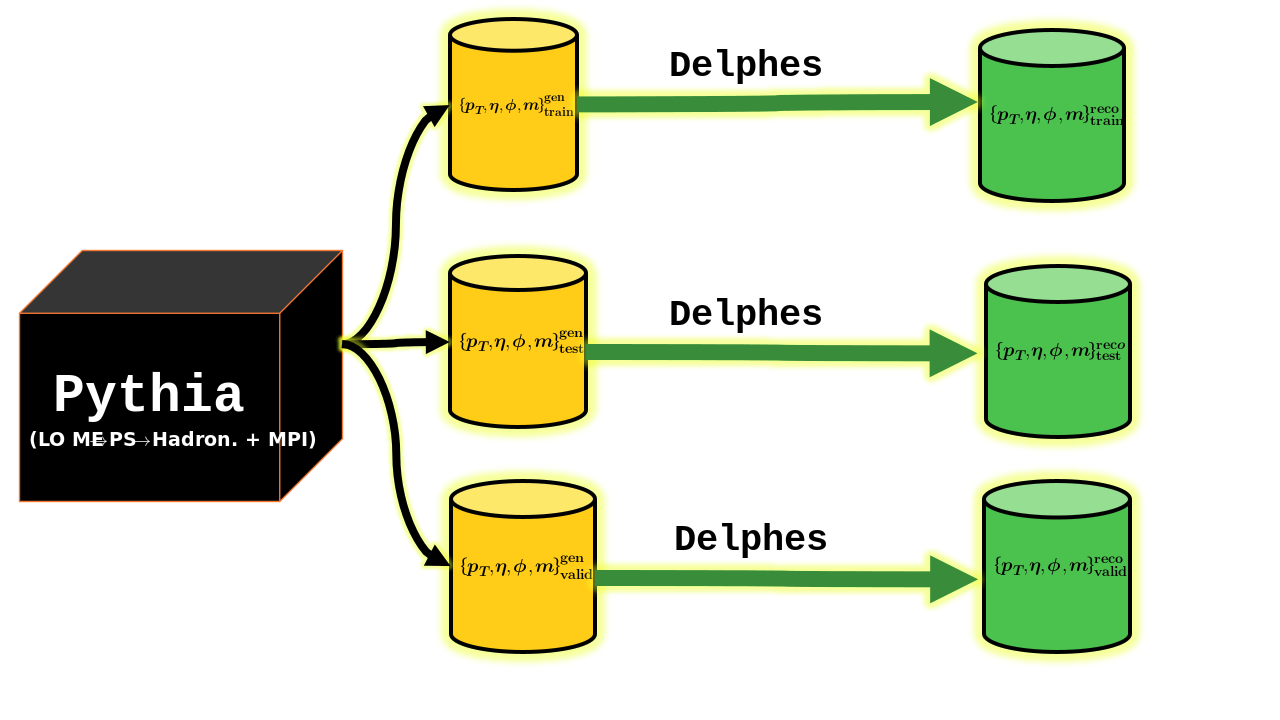

In [9]:
use_svg_display()
show_jupyter_image('images/pythia_ppt_diagram.png', width=2000,height=500)

Decide on an evaluation order 

In [13]:
################################### SET DATA CONFIGURATIONS ###################################
X       = ['genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']

#set order of training:
#pT_first: pT->>m->eta->phi
#m_first: m->pT->eta->phi



#we'll just go with m first since that's the order we discuss in the paper.
ORDER='m_First'

if ORDER=='m_First':
    FIELDS  = {'RecoDatam' : {'inputs': X, 
                               'xlabel':  r'$m$ (GeV)', 
                              'ylabel':'$m^{reco}$',
                               'xmin': 0, 
                               'xmax': 25},
                           

               'RecoDatapT': {'inputs': ['RecoDatam']+X, 
                               'xlabel':  r'$p_T$ (GeV)' , 
                              'ylabel': '$p_T^{reco}$',
                               'xmin'  : 20, 
                               'xmax'  :  80},

               'RecoDataeta': {'inputs': ['RecoDatam','RecoDatapT'] + X, 
                               'xlabel': r'$\eta$',
                               'ylabel':'$\eta^{reco}$',
                               'xmin'  : -5,
                               'xmax'  :  5},

               'RecoDataphi'  : {'inputs': ['RecoDatam', 'RecodatapT', 'RecoDataeta']+X,
                               'xlabel': r'$\phi$' ,
                                'ylabel' :'$\phi^{reco}$',
                               'xmin'  : -3.2, 
                               'xmax'  :3.2}
              }
    

all_variable_cols = [
    "genDatapT",
    "genDataeta",
    "genDataphi",
    "genDatam",
    "RecoDatapT",
    "RecoDataeta",
    "RecoDataphi",
    "RecoDatam",
]
all_cols = [
    "genDatapT",
    "genDataeta",
    "genDataphi",
    "genDatam",
    "RecoDatapT",
    "RecoDataeta",
    "RecoDataphi",
    "RecoDatam",
    "tau",
]

# 3. Load and explore raw (unscaled) dataframes

In [15]:
from joblib import  Memory
DATA_DIR = os.environ["DATA_DIR"]
print(f"using DATA_DIR={DATA_DIR}")

memory = Memory(DATA_DIR)

print("USING NEW DATASET\n")
######################################
USE_BRADEN_SCALING=False
#####################################
################################### CONFIGURATIONS ###################################
@memory.cache
def load_raw_data():
    print(f'SUBSAMPLE = {SUBSAMPLE}')
    raw_train_data=pd.read_csv(os.path.join(DATA_DIR,'train_data_10M_2.csv'),
                        usecols=all_cols,
                        nrows=SUBSAMPLE
                        )

    raw_test_data=pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'),
                        usecols=all_cols,
                        nrows=SUBSAMPLE
                        )

    raw_valid_data=pd.read_csv(os.path.join(DATA_DIR,'validation_data_10M_2.csv'),
                        usecols=all_cols,
                        nrows=SUBSAMPLE
                        )


    print('\n RAW TRAIN DATA SHAPE\n')
    print(raw_train_data.shape)
    print('\n RAW TRAIN DATA\n')
    raw_train_data.describe()#unscaled
    print('\n RAW TEST DATA\ SHAPEn')
    print(raw_test_data.shape)
    print('\n RAW TEST DATA\n')
    raw_test_data.describe()#unscaled

    return raw_train_data, raw_test_data, raw_valid_data

    
JUPYTER = False
use_subsample = False
# use_subsample = True
if use_subsample:
    SUBSAMPLE = int(
        1e5
    )  # subsample use for development - in production use whole dataset
else:
    SUBSAMPLE = None




########################################################################################
raw_train_data, raw_test_data, raw_valid_data =load_raw_data()

using DATA_DIR=/home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data
USING NEW DATASET

________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3950853832.load_raw_data...
load_raw_data()
SUBSAMPLE = None

 RAW TRAIN DATA SHAPE

(8000000, 9)

 RAW TRAIN DATA


 RAW TEST DATA\ SHAPEn
(1000000, 9)

 RAW TEST DATA

___________________________________________________load_raw_data - 13.3s, 0.2min


In [16]:
def explore_data(df, title, scaled=False):
    fig, ax = plt.subplots(1,5, figsize=(15,10) )
    # df = df[['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam']]
    levels = ['RecoData', 'genData']
    kinematics=['pT','eta','phi','m']
    columns = [level+k for level in levels for k in kinematics]
    print(columns)
    columns = columns + ['tau']
    print(columns)
    df = df[columns]
    
    for k_i, k in enumerate(kinematics):
        Reco_var = levels[0]+k
        gen_var = levels[1]+k
        print('Reco_var: ', Reco_var, ', \t gen_var: ', gen_var)
        ax[k_i].hist(df[Reco_var], bins=100, label=Reco_var, alpha=0.35)
        ax[k_i].hist(df[gen_var], bins=100, label=gen_var, alpha=0.35)
        xmin, xmax = FIELDS[Reco_var]['xmin'], FIELDS[Reco_var]['xmax']
        xlabel=FIELDS[Reco_var]['xlabel']
        ax[k_i].set_xlim( (xmin, xmax) )
        # set_axes(ax[k_i], xlabel=xlabel, ylabel='', xmin=xmin, xmax=xmax)
        ax[k_i].set_xlabel(xlabel,fontsize=26)
        
        
                  
        if scaled:
            ax[k_i].set_xlim(df[gen_var].min(),df[gen_var].max() )
        
        ax[k_i].legend(loc='best', fontsize=13)
    ax[4].hist(df['tau'],bins=100, label=r'$\tau$')
    ax[4].legend(loc='best', fontsize=13)
    fig.suptitle(title, fontsize=30)
    show_plot()

['RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'genDatapT', 'genDataeta', 'genDataphi', 'genDatam']
['RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']
Reco_var:  RecoDatapT , 	 gen_var:  genDatapT
Reco_var:  RecoDataeta , 	 gen_var:  genDataeta
Reco_var:  RecoDataphi , 	 gen_var:  genDataphi
Reco_var:  RecoDatam , 	 gen_var:  genDatam


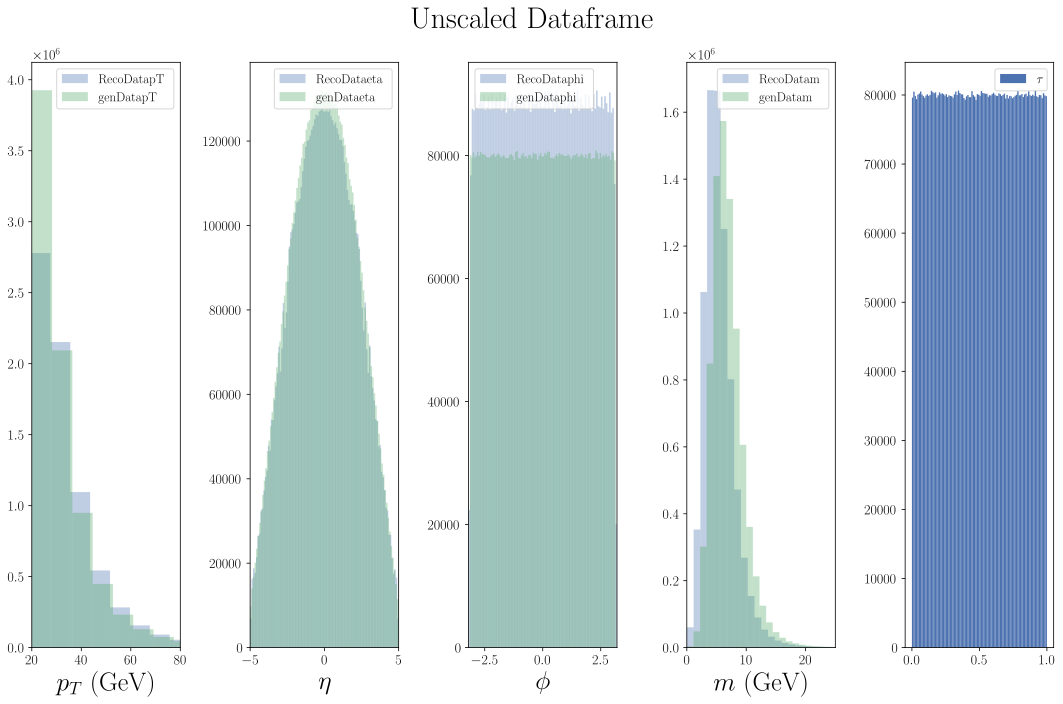

In [17]:
explore_data(df=raw_train_data, title='Unscaled Dataframe')

In [18]:
print(raw_train_data.shape)
raw_train_data.describe()#unscaled

(8000000, 9)


,genDatapT,genDataeta,genDataphi,genDatam,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,tau
count,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06,8.000000e+06
mean,3.269523e+01,-1.781882e-03,-3.830903e-04,6.962994e+00,3.286720e+01,-1.789886e-03,-4.719170e-04,5.555567e+00,4.999153e-01
std,1.493793e+01,2.204310e+00,1.813825e+00,2.781332e+00,1.582936e+01,2.197969e+00,1.814474e+00,2.664340e+00,2.886730e-01
min,2.000000e+01,-5.227320e+00,-3.141590e+00,-7.042220e-04,1.144390e+01,-5.006930e+00,-3.480195e+00,-8.631670e-05,5.075658e-08
25%,2.376670e+01,-1.654600e+00,-1.571320e+00,5.116180e+00,2.348440e+01,-1.651130e+00,-1.571500e+00,3.805560e+00,2.498142e-01
50%,2.840240e+01,-2.726765e-03,6.159285e-05,6.537620e+00,2.898930e+01,-3.001240e-03,-4.192835e-05,5.120820e+00,4.999874e-01
75%,3.627690e+01,1.651250e+00,1.570300e+00,8.282190e+00,3.749822e+01,1.647990e+00,1.570142e+00,6.774150e+00,7.500011e-01
max,8.397820e+02,5.188200e+00,3.141590e+00,1.112440e+02,8.148800e+02,5.005230e+00,3.482885e+00,1.139730e+02,9.999999e-01


In [19]:
print(raw_test_data.shape)
raw_test_data.describe()#unscaled

(1000000, 9)


,genDatapT,genDataeta,genDataphi,genDatam,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,tau
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06
mean,32.665481,0.002822,-0.000512,6.957271,32.849094,0.002815,-0.000550,5.554067,4.997935e-01
std,14.746671,2.202514,1.814159,2.765754,15.617181,2.196167,1.814699,2.644894,2.888304e-01
min,20.000000,-5.159990,-3.141590,-0.000566,11.475300,-4.999270,-3.477685,-0.000061,2.595965e-07
25%,23.759175,-1.648685,-1.571470,5.111978,23.489400,-1.644865,-1.571400,3.806208,2.496069e-01
50%,28.395500,0.000701,-0.001251,6.532905,28.992800,0.001701,-0.000872,5.119875,4.996784e-01
75%,36.294825,1.654850,1.571060,8.277790,37.563675,1.651652,1.570125,6.775580,7.503565e-01
max,553.745000,5.143080,3.141590,77.079700,516.104000,5.005660,3.478095,75.951300,9.999998e-01


In [25]:
# np.array(train_data['genDatapT'])

# Scaling

scaling (or standarization, normalization) is someimes done in the following way:
$$ X' = \frac{X-X_{min}}{X_{max}-X_{min}} \qquad \rightarrow \qquad X= X' (X_{max}-X_{min}) + X_{min}$$

In [26]:
# def standarize(values):
#     expected_min, expected_max = values.min(), values.max()
#     scale_factor = expected_max - expected_min
#     offset = expected_min
#     standarized_values = (values - offset)/scale_factor 
#     return standarized_values

Or by taking z-score:

$$ X'=z(X)=\frac{X-E[X]}{\sigma_{X}}  \qquad \rightarrow \qquad X = z^{-1}(X')= X' \sigma_{X} + E[X].$$


-----------

## Basically a "standard scaling procedure" is the following (background):

1. Split the data into train and test dataframes
2. Fit on the train set, and transform everything according to the train set, that is, get the mean and std, ( optionally and min and max or other quantities) of each feature (column) of each of the train set, and standarize everything according to that.
3. transform each of the train and test sets independently. That is, use the means and stds of each column to transform a column $X$ into a column $X'$ e.g. according to 
$$ X'=z(X)= \frac{X-E[X]}{\sigma_{X}}$$
4. Train NN on transformed features $X_{train}'$ (and target $y_{train}'$) (in train df, but validate on test set, which will not influence the weights of NN ( just used for observation that it doesnt overfit) )
5. Once the training is done, *evaluate the NN on transformed features of the test set* $X_{test}'$, i.e. do $NN(X_{test}')$, which will result in a scaled prediction of the target $y_{pred}'$
6. Unscale the $y_{pred}'$, i.e. apply the inverse of the scaling operation, e.g.
$$ y_{pred}=z^{-1}(y_{pred}')= y_{pred}' \sigma_{y} + E[y]$$,
where 

$$\sigma_y$$

and 

$$E[y]$$

are attained from the test set *prior to training and scaling*.

7. Compare to $y$ (the actual distribution you're trying to estimate) one-to-one

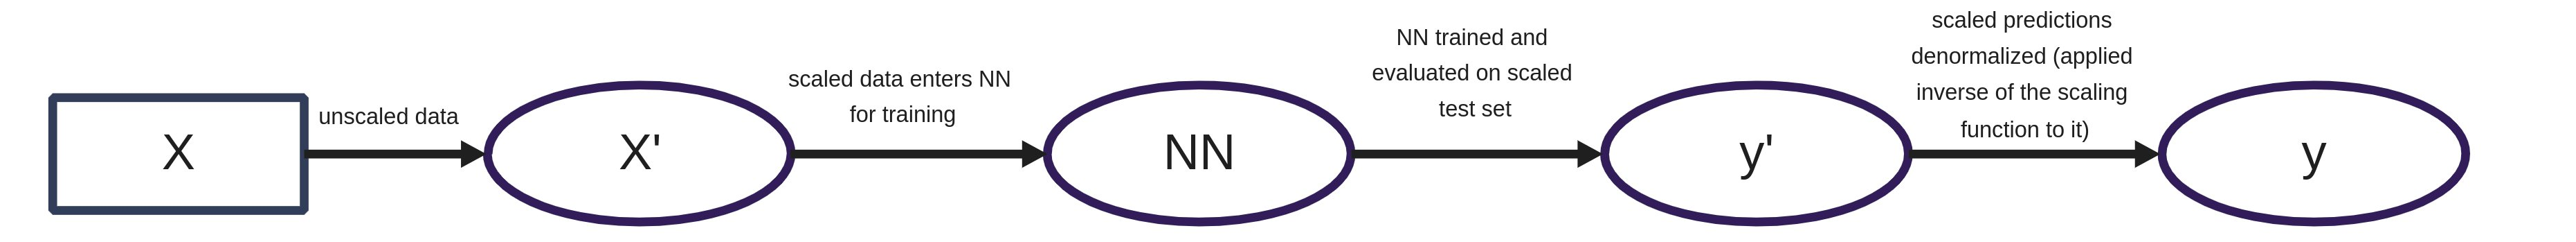

In [27]:
use_svg_display()
show_jupyter_image('images/scaling_forNN.jpg', width=2000,height=500)

# Braden scaling 

In the IQN-scipost overleaf, we say the scaling is the following:

$$\mathbb{T}(p_T) = z(\log p_T), \qquad \mathbb{T}(\eta) = z(\eta), \qquad \mathbb{T}(\phi) = z(\phi), \qquad \mathbb{T}(m) = z(\log (m + 2))$$ 

$$ \mathbb{T}(\tau) = 6\tau - 3 $$


Which means, for a jet observable $\mathcal{O}$ (or quantile $\tau$), the Braden-scaling perscribes that the data is first scaled according to:

$$
\begin{align}
    \mathbb{L} (\mathcal{O} \mid \mathcal{O} \in X ) &=
    \begin{cases}
        z \left( \log{\mathcal{O}} \right), \qquad & \text{if } \mathcal{O}= p_T \\
        z \left(\mathcal{O} \right), \qquad & \text{if } \mathcal{O}=\eta \\
        z \left( \log (\mathcal{O} + 2) \right), \qquad & \text{if } \mathcal{O}=m \\
        z \left( \mathcal{O} \right), \qquad & \text{if } \mathcal{O}=\phi \\
        z \left( 6 \mathcal{O} -3 \right), \qquad & \text{if } \mathcal{O}=\tau
    \end{cases}
\end{align}
$$

Note that the equation above describes the scaling for the training features $X$. The point of taking the log is 

The targets, as we say in the paper, are chosen to be the following:

$$
z\left(\frac{y_n + 10}{x_n + 10}\right), \qquad n = 1,\cdots,4,
\label{eq:normalization}
$$

We mean that the predicted target for a desired reco observable $\mathcal{O}$ is chosen to be the following function

$$
    \mathbb{T}(\mathcal{O} \mid \mathcal{O} \in y) = z \left( \frac{\mathbb{L} (\mathcal{O}^{\text{reco}}) +10 }{\mathbb{L}(\mathcal{O}^{\text{gen}}) +10} \right),
$$

where for a random variable $x$, $z$ is the standardization function (z-score):

$$
   x'= z (x) \equiv \frac{x-\bar{x}}{\sigma_{x}} \ .
$$

Such that its inverse is 

$$ z^{-1}(x') = x' \ \sigma_x + \bar{x} $$

If we do this on the data, after training, the NN $f_{\text{IQN}}$ will not estimate the observable, 

$$\mathcal{O}^{\text{predicted}} \ne \mathcal{O}^{\text{reco}}$$

but will instead estimate 

$$
        f_{\text{IQN}} (\mathcal{O}) \approx  z \left( \frac{\mathbb{L} (\mathcal{O}^{\text{reco}}) +10 }{\mathbb{L}(\mathcal{O}^{\text{gen}}) +10} \right),
$$

which needs to be de-scaled (when evaluated on the data that which has been scaled according to 

$$\mathbb{T}(\text{evaluation data}) = z \left( \frac{\mathbb{L} (\text{data}^{\text{reco}}) +10 }{\mathbb{L}(\text{data}^{\text{gen}}) +10} \right) $$


in order to copare with $\mathcal{O}$ directly.) The descaling for $\mathcal{O}=p_T$ (as an example) would be:

$$
    p_T^{\text{predicted}} = \mathbb{L}^{-1} \left[ z^{-1} (f_{\text{IQN}} ) \left[ \mathbb{L} (p_T^\text{gen})+10 \right] -10 \right]
$$


-------------

# 4. (Optional) Scale the data accoding to the "Braden Kronheim scaling" :


In [20]:
TRAIN_SCALE_DICT = get_scaling_info(raw_train_data);print(TRAIN_SCALE_DICT)
print('\n\n')
TEST_SCALE_DICT = get_scaling_info(raw_test_data);print(TEST_SCALE_DICT)

{'genDatapT': {'mean': 32.695234084987476, 'std': 14.937932540562551}, 'genDataeta': {'mean': -0.0017818817154031672, 'std': 2.204309760627079}, 'genDataphi': {'mean': -0.0003830903308450233, 'std': 1.8138251604791067}, 'genDatam': {'mean': 6.962994352358474, 'std': 2.781332025286383}, 'RecoDatapT': {'mean': 32.86720151648752, 'std': 15.829355769531851}, 'RecoDataeta': {'mean': -0.0017898858568513964, 'std': 2.197968491495457}, 'RecoDataphi': {'mean': -0.0004719170328962474, 'std': 1.8144739820043825}, 'RecoDatam': {'mean': 5.555567451922438, 'std': 2.664339857066051}}



{'genDatapT': {'mean': 32.6654809616, 'std': 14.746663776411731}, 'genDataeta': {'mean': 0.002821766734118711, 'std': 2.2025132218012735}, 'genDataphi': {'mean': -0.0005116820324618385, 'std': 1.8141583811877282}, 'genDatam': {'mean': 6.957271011526192, 'std': 2.765752894623606}, 'RecoDatapT': {'mean': 32.8490938466, 'std': 15.617172793936655}, 'RecoDataeta': {'mean': 0.0028149588128446, 'std': 2.196165457846061}, 'Re

In [ ]:
def L(orig_observable, label):
    eps=1e-20
    orig_observable=orig_observable+eps
    if label=='pT':
        const=0
        log_pT_=np.log(orig_observable) 
        L_observable = log_pT_
    if label=='eta':
        const=0
        L_observable=orig_observable
    if label=='m':
        const=2
        L_observable=np.log(orig_observable + const)
    if label=='phi':
        L_observable=orig_observable
    if label=='tau':
        L_observable=orig_observable
#         L_observable = (6*orig_observable) - 3
    
    return L_observable.to_numpy()

In [ ]:
def L_inverse(L_observable, label):
    eps=1e-20
    L_observable=L_observable+eps
    if label=='pT':
        const=0
        L_inverse_observable = np.exp(L_observable)
    if label=='eta':
        L_inverse_observable = L_observable
    if label=='m':
        const=2
        L_inverse_observable = np.exp(L_observable) - const
    if label=='tau':
        L_inverse_observable=L_observable
        # L_inverse_observable = (L_observable+3)/6
        
    if not isinstance(L_inverse_observable, np.ndarray):
        L_inverse_observable = L_inverse_observable.to_numpy()
    return L_inverse_observable

$$
    \mathbb{T}(\mathcal{O}) = z \left( \frac{\mathbb{L} (\mathcal{O}^{\text{reco}}) +10 }{\mathbb{L}(\mathcal{O}^{\text{gen}}) +10} \right),
$$


In [33]:
def T(variable, scaled_df):
    if variable=='pT':
        L_pT_gen=scaled_df['genDatapT']
        L_pT_reco = scaled_df['RecoDatapT']
        target = (L_pT_reco+10)/(L_pT_gen+10) 
    if variable=='eta':
        L_eta_gen=scaled_df['genDataeta']
        L_eta_reco = scaled_df['RecoDataeta']
        target =  (L_eta_reco+10)/(L_eta_gen+10) 
    if variable=='phi':
        L_phi_gen=scaled_df['genDataphi']
        L_phi_reco = scaled_df['RecoDataphi']
        target =  (L_phi_reco+10)/(L_phi_gen+10) 
    if variable=='m':
        L_m_gen=scaled_df['genDatam']
        L_m_reco = scaled_df['RecoDatam']
        target =  (L_m_reco+10)/(L_m_gen+10) 
    
    return target

In [34]:
def L_scale_df(df, title, save=False):
    #scale
    # SUBSAMPLE=int(1e6)
    df = df[all_cols]#[:SUBSAMPLE]
    # print(df.head())
    scaled_df = pd.DataFrame()
    #select the columns by index: 
    # 0:genDatapT, 1:genDataeta, 2:genDataphi, 3:genDatam, 
    # 4:RecoDatapT, 5:RecoDataeta, 6:RecoDataphi, 7: Recodatam
    scaled_df['genDatapT'] = L(df.iloc[:,0], label='pT')
    scaled_df['RecoDatapT'] = L(df.iloc[:,4], label='pT')
    
    scaled_df['genDataeta'] = L(df.iloc[:,1], label='eta')
    scaled_df['RecoDataeta'] = L(df.iloc[:,5],label='eta')
    
    
    scaled_df['genDataphi'] = L(df.iloc[:,2],label='phi')
    scaled_df['RecoDataphi'] = L(df.iloc[:,6],label='phi')

    scaled_df['genDatam'] = L(df.iloc[:,3],label='m')
    scaled_df['RecoDatam'] = L(df.iloc[:,7],label='m')
    #why scale tau?
    # scaled_df['tau'] = 6 * df.iloc[:,8] - 3
    scaled_df['tau'] = L(df.iloc[:,8],label='tau')
    
    print(scaled_df.describe())
    
    if save:
        scaled_df.to_csv(os.path.join(DATA_DIR, title) )
    return scaled_df

## If you want to generate the Scaled data frames, run the cell below

          genDatapT    RecoDatapT    genDataeta   RecoDataeta    genDataphi  \
count  8.000000e+06  8.000000e+06  8.000000e+06  8.000000e+06  8.000000e+06   
mean   3.421245e+00  3.412002e+00 -1.781882e-03 -1.789886e-03 -3.830903e-04   
std    3.348063e-01  3.804798e-01  2.204310e+00  2.197969e+00  1.813825e+00   
min    2.995732e+00  2.437457e+00 -5.227320e+00 -5.006930e+00 -3.141590e+00   
25%    3.168285e+00  3.156336e+00 -1.654600e+00 -1.651130e+00 -1.571320e+00   
50%    3.346474e+00  3.366927e+00 -2.726765e-03 -3.001240e-03  6.159285e-05   
75%    3.591181e+00  3.624294e+00  1.651250e+00  1.647990e+00  1.570300e+00   
max    6.733142e+00  6.703041e+00  5.188200e+00  5.005230e+00  3.141590e+00   

        RecoDataphi      genDatam     RecoDatam           tau  
count  8.000000e+06  8.000000e+06  8.000000e+06  8.000000e+06  
mean  -4.719170e-04  2.150564e+00  1.967802e+00  4.999153e-01  
std    1.814474e+00  2.880059e-01  3.271235e-01  2.886730e-01  
min   -3.480195e+00  6.927950e-0

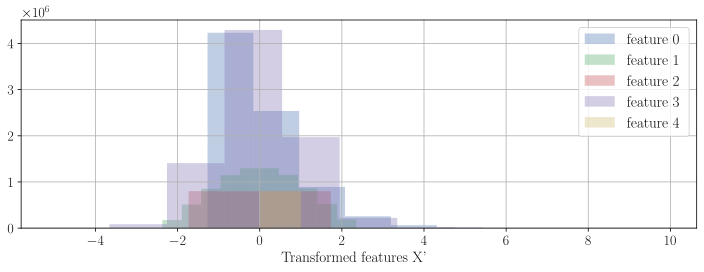

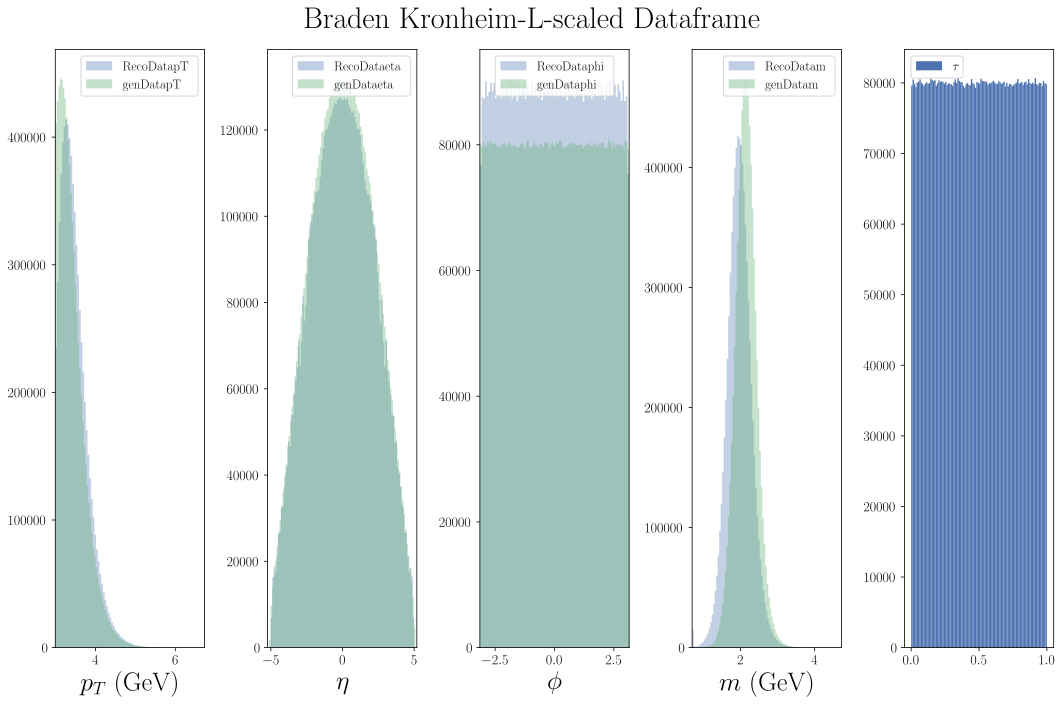

In [51]:
scaled_train_data = L_scale_df(raw_train_data, title='scaled_train_data_10M_2.csv',
                             save=True)
print('\n\n')
scaled_test_data = L_scale_df(raw_test_data,  title='scaled_test_data_10M_2.csv',
                            save=True)
print('\n\n')

scaled_valid_data = L_scale_df(raw_valid_data,  title='scaled_valid_data_10M_2.csv',
                            save=True)

explore_data(df=scaled_train_data, title='Braden Kronheim-L-scaled Dataframe', scaled=True)

## If you want to load the previously generated scaled dataframe, run the cell below

In [35]:
target = 'RecoDatam'
source  = FIELDS[target]
features= source['inputs']
########

print('USING NEW DATASET\n')
#UNSCALED
# train_data_m=pd.read_csv(os.path.join(DATA_DIR,'train_data_10M_2.csv'),
#                        usecols=features,
#                        nrows=SUBSAMPLE)

# print('TRAINING FEATURES\n', train_data.head())

# test_data_m= pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'),
#                        usecols=features,
#                        nrows=SUBSAMPLE)
# print('\nTESTING FEATURES\n', test_data.head())
# valid_data= pd.read_csv(os.path.join(DATA_DIR,'valid_data_10M_2.csv'),
#                        usecols=features,
#                        nrows=SUBSAMPLE)


# SCALED
train_data_m=pd.read_csv(os.path.join(DATA_DIR,'scaled_train_data_10M_2.csv'),
                       usecols=all_cols,
                       nrows=SUBSAMPLE)

print('TRAINING FEATURES\n', train_data_m.head())

test_data_m= pd.read_csv(os.path.join(DATA_DIR,'scaled_test_data_10M_2.csv'),
                       usecols=all_cols,
                       nrows=SUBSAMPLE)

valid_data_m= pd.read_csv(os.path.join(DATA_DIR,'scaled_valid_data_10M_2.csv'),
                       usecols=all_cols,
                       nrows=SUBSAMPLE)
print('\nTESTING FEATURES\n', test_data_m.head())

print('\ntrain set shape:',  train_data_m.shape)
print('\ntest set shape:  ', test_data_m.shape)
# print('validation set shape:', valid_data.shape)

scaled_train_data = train_data_m
scaled_test_data = test_data_m
scaled_valid_data = valid_data_m

USING NEW DATASET

TRAINING FEATURES
    genDatapT  RecoDatapT  genDataeta  RecoDataeta  genDataphi  RecoDataphi  \
0   3.382531    3.463020    0.828187     0.817082    2.902130     2.919510   
1   3.191270    3.308764   -1.163510    -1.151020    0.636469     0.652153   
2   3.191270    3.308764   -1.163510    -1.151020    0.636469     0.652153   
3   3.191270    3.308764   -1.163510    -1.151020    0.636469     0.652153   
4   3.004211    3.187005    1.844410     1.837910   -0.186685    -0.160621   

   genDatam  RecoDatam       tau  
0  1.579696   1.525158  0.361310  
1  2.058837   1.995432  0.126899  
2  2.058837   1.995432  0.962307  
3  2.058837   1.995432  0.457282  
4  2.040038   1.886115  0.840862  

TESTING FEATURES
    genDatapT  RecoDatapT  genDataeta  RecoDataeta  genDataphi  RecoDataphi  \
0   3.775316    3.791603    0.824891     0.824645    -1.26949     -1.26117   
1   3.775316    3.791603    0.824891     0.824645    -1.26949     -1.26117   
2   3.258685    3.313277    3.

/tmp/ipykernel_1098681/3184480508.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


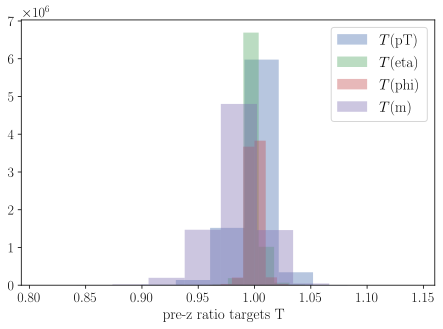

In [36]:

labels = ['pT', 'eta','phi','m']
fig, ax=plt.subplots(1,1)
for label in labels:
    target_ = T(label, scaled_df=scaled_train_data)
    
    ax.hist(target_, label = '$T($' +label+ '$)$', alpha=0.4 )
set_axes(ax=ax, xlabel='pre-z ratio targets T', )
plt.show()

Our risk functional is minimized for

$$\frac{\delta R_{\text{IQN}x4} }{\delta f_m}=0\tag{5}$$

(which is basically what's done in the training process to get $f_m^{*}$ whose weights/parameters minimize the loss). Suppose we factorize the risk as

$$ R_{\text{IQN}x4}  = R_{\text{IQN}}^m \ R_{\text{IQN}}^{p_T}  \ R_{\text{IQN}}^\eta \ R_{\text{IQN}}^\phi \tag{6},$$ 

then, by Eq (4),

$$R_{\text{IQN}}^m \equiv \int L_\text{IQN} \left( f_m (\mathbf{x_m},\tau), \mathbf{y_m} \right) p(\mathbf{x_m, y_m,\tau})  d \mathbf{x_m} d \mathbf{y_m} d \mathbf{\tau},
$$
and by Eq (5)

$$\int d \mathbf{x_m} d \mathbf{y_m} d \mathbf{\tau} \ p(\mathbf{x_m, y_m,\tau})   \ \frac{ \delta L_\text{IQN} \left( f_m (\mathbf{x_m},\tau), \mathbf{y_m} \right) }{\delta f_m} = 0$$


and by Eq (2)

$$
\int d \mathbf{x_m} d \mathbf{y_m} d \mathbf{\tau} \ p(\mathbf{x_m, y_m,\tau})   \ \frac{ \delta L_\text{IQN} \left( f_m (\mathbf{x_m},\tau), \mathbf{y_m} \right) }{\delta f_m} = 0 \tag{7}
$$

>> ...
<br>

Expand Eq (2) in Eq (7) and integrate wrt y over the appropriate limits to see that  $f(\mathbf{x},\mathbf{\tau})$ is the quantile function for $p(\mathbf{y}|\mathbf{x})$, i.e. (I believe) that IQNx4 should work basically exactly.

$$R_{\text{IQN}x4} = [ L \left( f_m( \{ p_T^{\text{gen}}, \eta^{\text{gen}}, \phi^{\text{gen}}, m^{\text{gen}} , \tau \}, m^\text{reco} ) $$

# Train Mass

for mass, 

$$\mathbf{y_m}=m_{\text{reco}}$$

and 

$$\mathbf{x_m}=\{p_T^{\text{gen}}, \eta^{\text{gen}}, \phi^{\text{gen}}, m^{\text{gen}} , \tau \}.$$


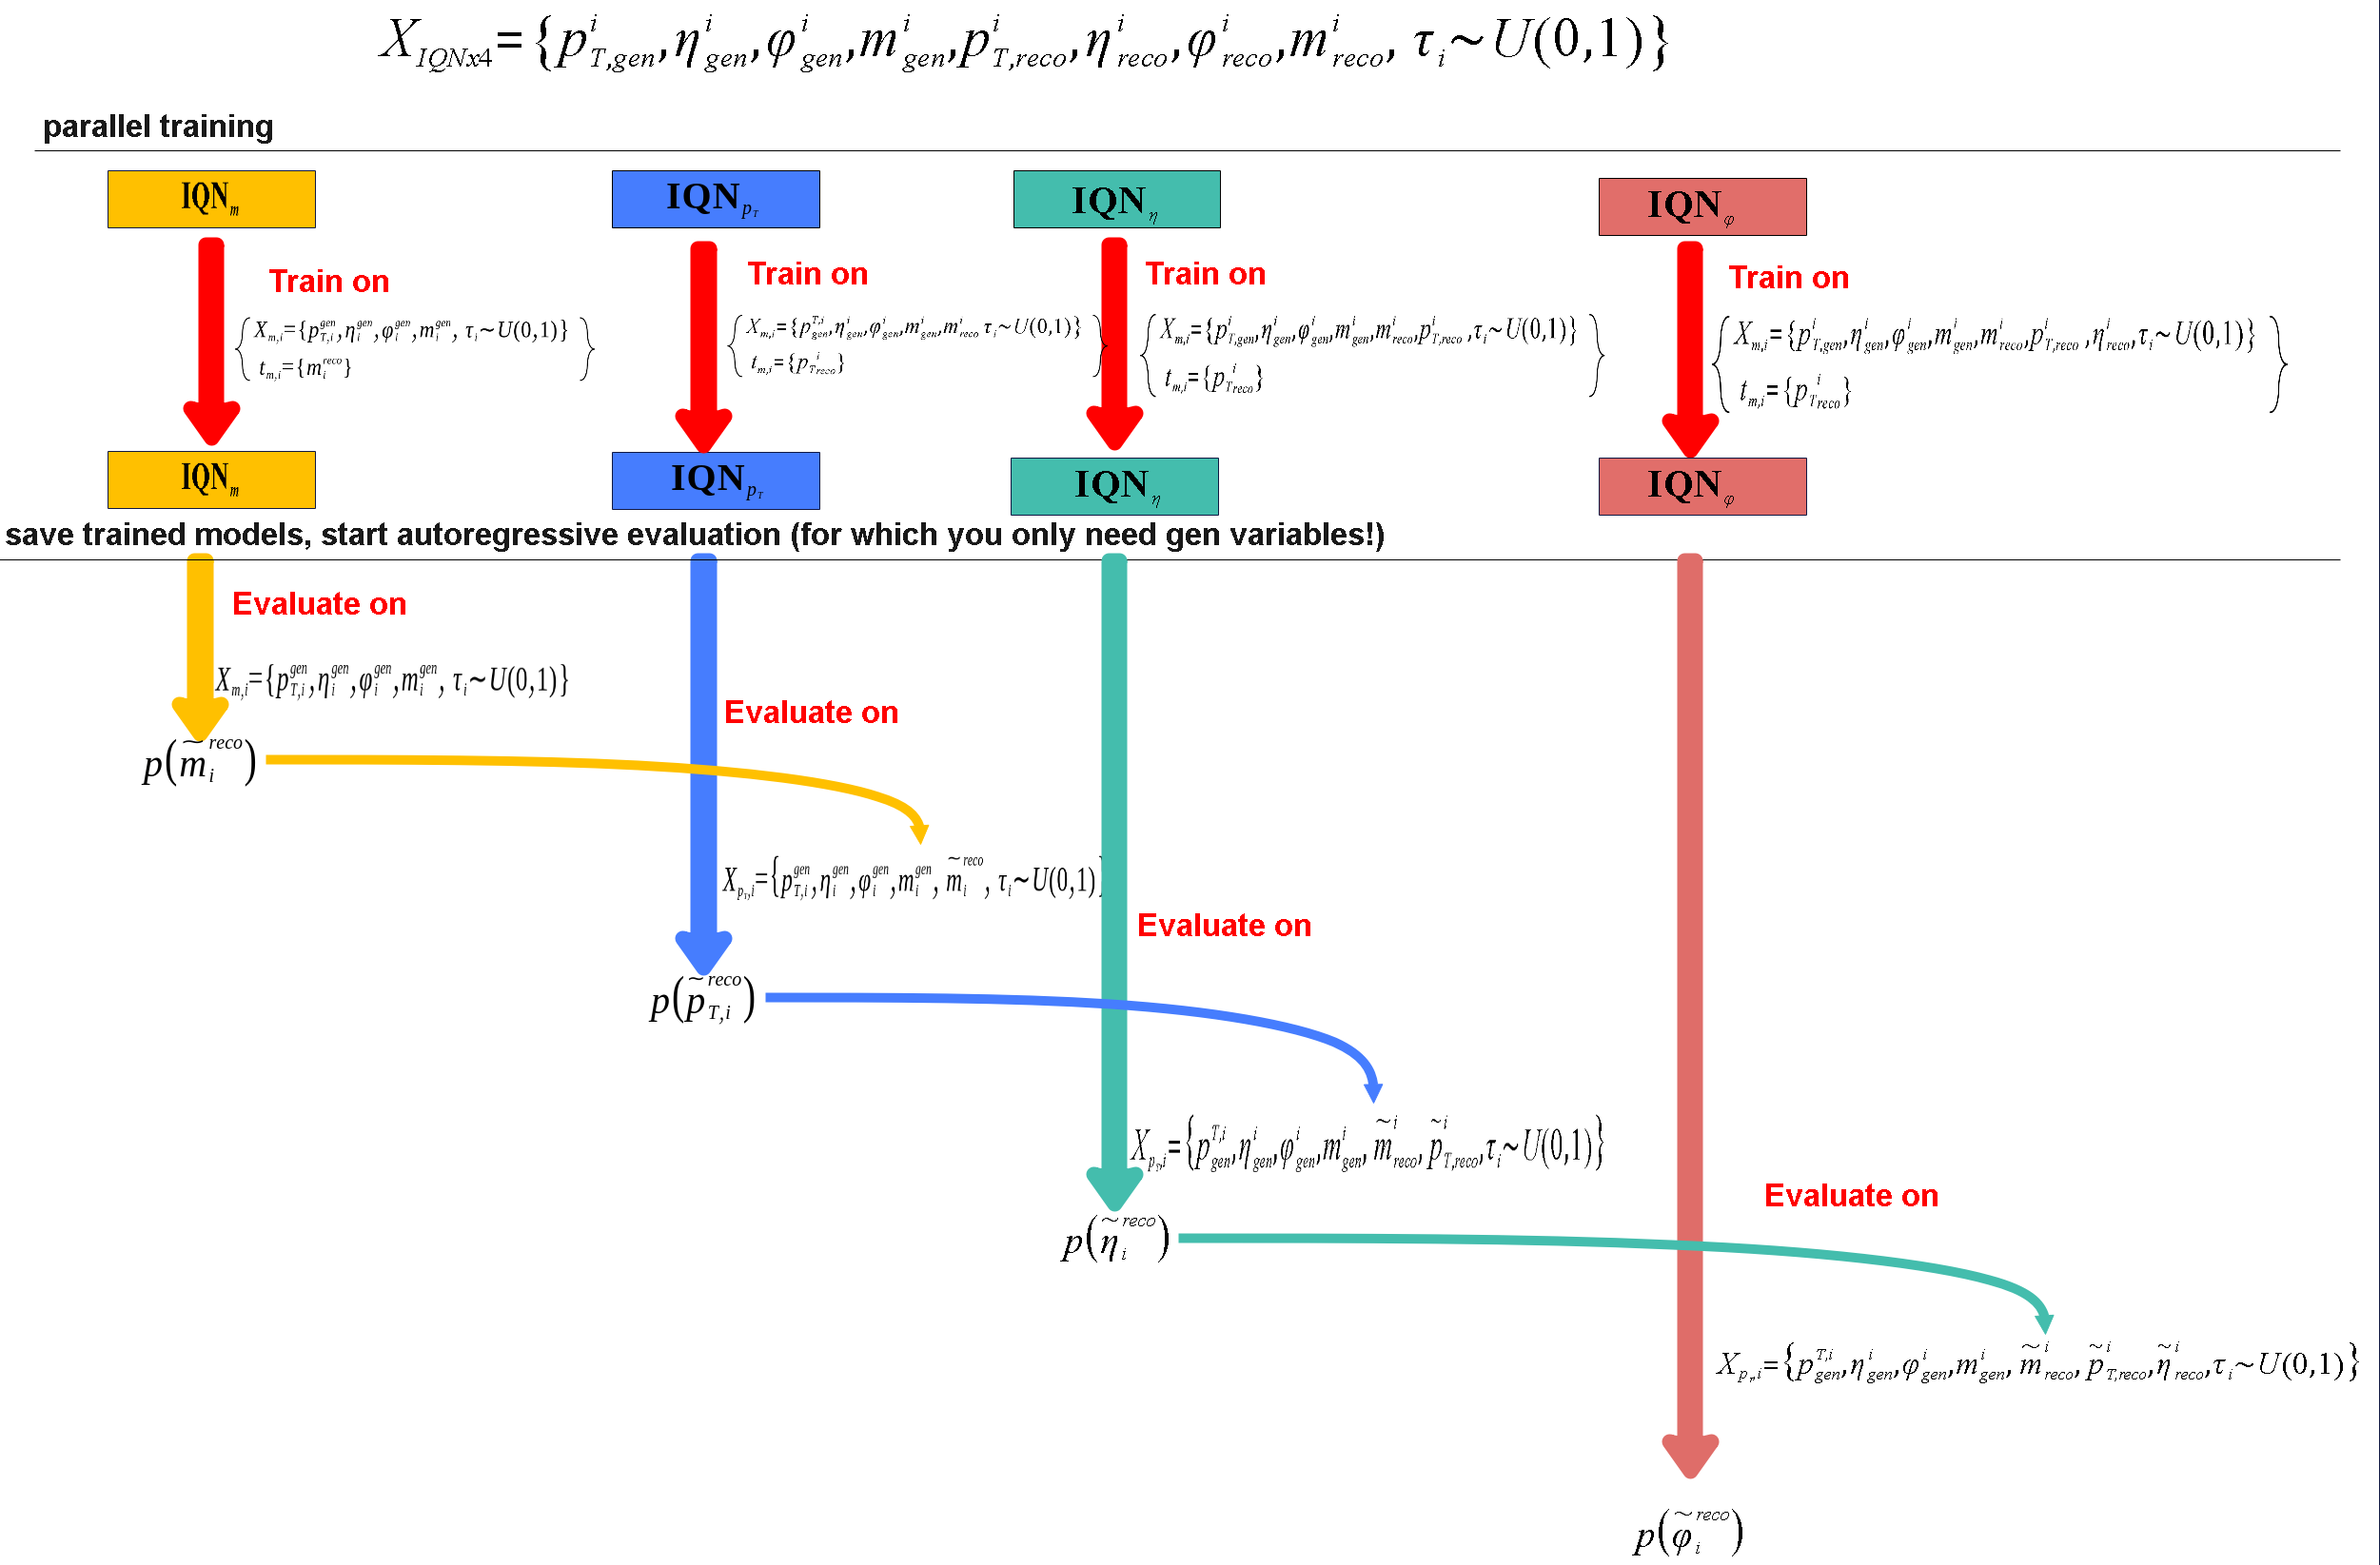

In [37]:
show_jupyter_image('images/IQN_training_flowchart.png',width=3000,height=1000)

In [46]:
apply_z_generator = apply_z_to_features()

train_x = next(apply_z_generator)
test_x = next(apply_z_generator)
valid_x = next(apply_z_generator)

print(valid_x.mean(axis=0), valid_x.std(axis=0))

print(train_x.mean(axis=0), train_x.std(axis=0))

[-2.55532484e-16  2.34408049e-17 -2.47215581e-17 -2.22109975e-15
  5.00485136e-01] [1.         1.         1.         1.         0.28852734]
[ 3.98275191e-15 -1.10134124e-18 -3.12905257e-17 -1.14646888e-14
  4.99915289e-01] [1.         1.         1.         1.         0.28867295]


In [47]:
train_x[:3,:], test_x[:3,:], valid_x[:3,:]

(array([[-0.11563106,  0.37652098,  1.60021658, -1.98214105,  0.36130954],
        [-0.68688865, -0.5270258 ,  0.35110997, -0.31849075,  0.12689925],
        [-0.68688865, -0.5270258 ,  0.35110997, -0.31849075,  0.96230681]]),
 array([[ 1.06101772,  0.37324145, -0.69948596, -0.27467897,  0.25004557],
        [ 1.06101772,  0.37324145, -0.69948596, -0.27467897,  0.84749256],
        [-0.48554751,  1.60141978,  0.85740126,  0.31973299,  0.85199529]]),
 array([[-0.68215953,  0.56054886, -0.34477387, -1.23054084,  0.93582274],
        [-0.2284882 ,  1.43668218, -0.12155883, -0.6725882 ,  0.9272482 ],
        [-0.2284882 ,  1.43668218, -0.12155883, -0.6725882 ,  0.37568739]]))

### Apply $z$ to targets before training

In [48]:
def apply_z_to_targets():
    train_t_ratio_ = z(train_t_ratio) 
    test_t_ratio_ = z(test_t_ratio) 
    valid_t_ratio_ = z(valid_t_ratio)
    
    yield train_t_ratio_
    yield test_t_ratio_
    yield valid_t_ratio_


In [49]:
apply_z_to_targets_generator = apply_z_to_targets()
train_t_ratio = next(apply_z_to_targets_generator)
test_t_ratio = next(apply_z_to_targets_generator)
valid_t_ratio = next(apply_z_to_targets_generator)

print(valid_t_ratio.mean(), valid_t_ratio.std())
print(train_t_ratio.mean(), train_t_ratio.std())

5.849882889208402e-14 1.0000000000000004
5.849882889208402e-14 1.0000000000000004


In [1]:
#check that it looks correct
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(autoscale_on=True)
ax.grid()
for i in range(NFEATURES):
    ax.hist(train_x[:,i], alpha=0.35, label=f'feature {i}' )
    # set_axes(ax=ax, xlabel="Transformed features X' ",title="training features post-z score: X'=z(L(X))")
ax.legend()
plt.show()

NameError: name 'plt' is not defined

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [51]:
train_x[:,-1].max()

0.9999999358588744


### Training and running-of-training functions

### Define basic NN model

In [52]:
class RegularizedRegressionModel(nn.Module):
    """Used for hyperparameter tuning """
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                # layers.append(nn.BatchNorm1d(hidden_size))
                #dropout only in the first layer
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.LeakyReLU())
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                # layers.append(nn.Dropout(dropout))
                layers.append(nn.LeakyReLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 

        # only for classification add sigmoid
        # layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)
    
    
class TrainingRegularizedRegressionModel(nn.Module):
    """Used for training, and adds more regularization to prevent overfitting """
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                layers.append(nn.BatchNorm1d(hidden_size))
                #dropout only in the first layer
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.LeakyReLU())
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                layers.append(nn.LeakyReLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 

        # only for classification add sigmoid
        # layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)

--------
-------

## Hyperparameter Training Workflow

We should not touch our test set until we have chosen our hyperparameters (have done model selection) using the valid set (also, we can't tune the model using the train set since it obviously will just overfit the train set). Then in the training process we evaluate on test set to keep ourselves honest and to see if we are overfitting the train set. 

It seems that one of the big challenges in this project is generalization (or overfitting). ways to reduce overfitting and improve generalization (that is, make the generalization error $R[f]$ closer to the training error $R_{\text{emp}}$ is: 

1. Reducing model complexity (e.g. using a linear model instead of a non-linear model, and user fewer model parameters). 2. using more training data. 3. feature selecting (i.e. using fewer features, since some of the features might be irrelevant or redundant). 4. Data augmentation, i.e. generating additional training examples through e.g. horizontal flipping/random cropping for images, or adding noise to training examples, all of which increase the size and diversity of the training set. 5. Regularization techniques, such as adding a penalty to the weights of the model during training (weight decay). This penalty could be e.g. L1 or L2 norm of the weights. 5. Cross valudation: dividing the training set into several smaller sets, training the model on one set, and evaluating it on the others. (can use e.g. `sklearn.model_selection.KFold` instead of doing it from scratch). 

Other than overfitting, the name of the game for training of course is to minimize the loss with respect to the weights. INPUT (features) is forward propagated (meaning each layer is basically a matrix of the size of the weights is a matrix of $( N_inputs + 1) X (N_outputs)$ (and the inputs) is $w[N_inputs]+b$ which is the rows, and the outputs ($y=\mathbf{w}+b$) will have shape $[N_outputs]$  through each layer into the OUTPUT (target). More explicitly the shape of output $y$ of each layer will be

$$[y] = [1 \times (N_{input}+1) ] \cdot [(N_{input} +1) \times N_{output}] = [1\times N_{output}]  $$

Where $N_{input}$ and $N_{output}$ are the numbers of input and output features, taken to be rows and columns of the matrices, respectively. The $+1$ in $ (N_{input}+1) $ is for the bias column.


Forward Prop: pass.
INPUT $\mathbf{x}$ -> .... -> a bunch of layers ... -> OUTPUT $y$


Backprop.: Going backward from the output layer to the input layer. Basically, for one layer, $Backprop(dLoss/dy) = dLoss/dx$, where $x$ and $y$ are the inputs and outputs for one layer. This will use, in the simplest case, $dLoss/dx = dLoss/dy \ dy/dx$ where $ dy/dx$ will be in terms of the weights of the current layer. $dLoss/dw = dLoss/dy \ dy/dw$, and then the weights are updated as to minimize the loss, e.g. for SGD: $w \leftarrow w - (dLoss/dw \ \eta$ where $\eta$ is the learning rate.

the dLoss/dx becomes the dLoss/dy of the next layer:

X layer1 - > layer_2 .... -> layer_n -> y
<-...  dL/dx  <- BP dL/dy  <- dL/dx   <-BP  dL/dy

In [53]:
def get_tuning_sample():
    sample=int(200000)
    # train_x_sample, train_t_ratio_sample, valid_x_sample, valid_t_ratio_sample
    get_whole=True
    if get_whole:
        train_x_sample, train_t_ratio_sample, valid_x_sample, valid_t_ratio_sample = train_x, train_t_ratio, valid_x, valid_t_ratio
    else:
        train_x_sample, train_t_ratio_sample, valid_x_sample, valid_t_ratio_sample=train_x[:sample], train_t_ratio[:sample], valid_x[:sample], valid_t_ratio[:sample]
    return train_x_sample, train_t_ratio_sample, valid_x_sample, valid_t_ratio_sample

train_x_sample, train_t_ratio_sample, valid_x_sample, valid_t_ratio_sample = get_tuning_sample()
print(train_x_sample.shape)

(8000000, 5)


Need to use test set *and* validation set for tuning.

Note that hyperparameters are usually not directly transferrable across architectures and datasets. 

In [55]:
class HyperTrainer():
    """loss, training and evaluation"""
    def __init__(self, model, optimizer, batch_size):
                 #, device):
        self.model = model
        #self.device= device
        self.optimizer = optimizer
        self.batch_size=batch_size
        self.n_iterations_tune=int(50)

        #the loss function returns the loss function. It is a static method so it doesn't need self
        # @staticmethod
        # def loss_fun(targets, outputs):
        #   tau = torch.rand(outputs.shape)
        #   return torch.mean(torch.where(targets >= outputs, 
        #                                   tau * (targets - outputs), 
        #                                   (1 - tau)*(outputs - targets)))

        #     This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, 
        #     by combining the operations into one layer

    def train(self, x, t):

        self.model.train()
        final_loss = 0
        for iteration in range(self.n_iterations_tune):
            self.optimizer.zero_grad()
            batch_x, batch_t = get_batch(x, t,  self.batch_size)#x and t are train_x and train_t

            # with torch.no_grad():
            inputs=torch.from_numpy(batch_x).float()
            targets=torch.from_numpy(batch_t).float()
            outputs = self.model(inputs)
            loss = average_quantile_loss(outputs, targets, inputs)
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()

        return final_loss / self.batch_size

    def evaluate(self, x, t):

        self.model.eval()
        final_loss = 0
        for iteration in range(self.n_iterations_tune):
            batch_x, batch_t = get_batch(x, t,  self.batch_size)#x and t are train_x and train_t

            # with torch.no_grad():            
            inputs=torch.from_numpy(batch_x).float()
            targets=torch.from_numpy(batch_t).float()
            outputs = self.model(inputs)
            loss =average_quantile_loss(outputs, targets, inputs)
            final_loss += loss.item()
        return final_loss / self.batch_size

    
EPOCHS=1
def run_train(params, save_model=False):
    """For tuning the parameters"""

    model =  RegularizedRegressionModel(
              nfeatures=train_x_sample.shape[1], 
                ntargets=1,
                nlayers=params["nlayers"], 
                hidden_size=params["hidden_size"],
                dropout=params["dropout"]
                )
    # print(model)
    

    learning_rate= params["learning_rate"]
    optimizer_name = params["optimizer_name"]
    
    # optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"]) 
    
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), 
                            lr=learning_rate, momentum = params["momentum"])
    
    trainer=HyperTrainer(model, optimizer, batch_size=params["batch_size"])
    best_loss = np.inf
    early_stopping_iter=10#stop after 10 iteractions of not improving loss
    early_stopping_coutner=0

    # for epoch in range(EPOCHS):
    # train_loss = trainer.train(train_x_sample, train_t_ratio_sample)
        #test loss
    valid_loss=trainer.evaluate(valid_x_sample, valid_t_ratio_sample)

        # print(f"{epoch} \t {train_loss} \t {valid_loss}")
        
        # if valid_loss<best_loss:
        #     best_loss=valid_loss
        # else:
        #     early_stopping_coutner+=1
        # if early_stopping_coutner > early_stopping_iter:
            # break
            
    # return best_loss
    return valid_loss


def objective(trial):
    CLUSTER=False
    #cluster has greater memory than my laptop, which allows higher max values in hyperparam. search space
    if CLUSTER:
        nlayers_max,n_hidden_max, batch_size_max=int(24),int(350), int(2e5)
    else:
        nlayers_max,n_hidden_max, batch_size_max=int(6),int(256), int(3e4)

    #hyperparameter search space:
    params = {
          "nlayers": trial.suggest_int("nlayers",1,nlayers_max),      
          "hidden_size": trial.suggest_int("hidden_size", 1, n_hidden_max),
          "dropout": trial.suggest_float("dropout", 0.0,0.5),
          "optimizer_name" : trial.suggest_categorical("optimizer_name", ["RMSprop", "SGD"]),
          "momentum": trial.suggest_float("momentum", 0.0,0.99),
          "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-2),
          "batch_size": trial.suggest_int("batch_size", 500, batch_size_max)

        }
    
    for step in range(10):

        temp_loss = run_train(params,save_model=False)
        trial.report(temp_loss, step)
        #activate pruning (early stopping if the current step in the trial has unpromising results)
        #instead of doing lots of iterations, do less iterations and more steps in each trial,  
        #such that a trial is terminated if a step yields an unpromising loss.
        
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return temp_loss

@time_type_of_func(tuning_or_training='tuning')
def tune_hyperparameters(save_best_params):
    

    sampler=False#use different sampling technique than the defualt one if sampler=True.
    if sampler:
        #choose a different sampling strategy (https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.CmaEsSampler.html#optuna.samplers.CmaEsSampler)
        # sampler=optuna.samplers.RandomSampler()
        study=optuna.create_study(direction='minimize',
                                  pruner=optuna.pruners.MedianPruner(), sampler=sampler)
    else:
        #but the default sampler is usually better - no need to change it!
        study=optuna.create_study(direction='minimize',
                                  pruner=optuna.pruners.HyperbandPruner())
    n_trials=100
    study.optimize(objective, n_trials=n_trials)
    best_trial = study.best_trial
    print('best model parameters', best_trial.params)

    best_params=best_trial.params#this is a dictionary
    #save best hyperapameters in a pandas dataframe as a .csv
    if save_best_params:
        tuned_dir = os.path.join(IQN_BASE,'best_params')
        mkdir(tuned_dir)
        filename=os.path.join(tuned_dir,'best_params_mass_%s_trials.csv' % str(int(n_trials)))
        param_df=pd.DataFrame({
                                'n_layers':best_params["nlayers"], 
                                'hidden_size':best_params["hidden_size"], 
                                'dropout':best_params["dropout"],
                                'optimizer_name':best_params["optimizer_name"],
                                'learning_rate': best_params["learning_rate"], 
                                'batch_size':best_params["batch_size"],
                                'momentum':best_params["momentum"]},
                                        index=[0]
        )

        param_df.to_csv(filename)   
    return study

In [56]:
study= tune_hyperparameters(save_best_params=True)

[I 2022-12-19 07:27:17,221] A new study created in memory with name: no-name-63a63233-8a78-4938-bda9-27e414ed403b


tuning IQN hyperparameters to estimate RecoDatam
Getting best hyperparameters for target RecoDatam


[I 2022-12-19 07:28:46,262] Trial 0 finished with value: 0.003622715896944553 and parameters: {'nlayers': 6, 'hidden_size': 216, 'dropout': 0.4673854658963708, 'optimizer_name': 'RMSprop', 'momentum': 0.6220901295466295, 'learning_rate': 0.00482947458383595, 'batch_size': 5252}. Best is trial 0 with value: 0.003622715896944553.
[I 2022-12-19 07:29:49,604] Trial 1 finished with value: 0.004772787794865617 and parameters: {'nlayers': 6, 'hidden_size': 162, 'dropout': 0.30345750255905246, 'optimizer_name': 'SGD', 'momentum': 0.14140136413515197, 'learning_rate': 0.005517767125136827, 'batch_size': 4076}. Best is trial 0 with value: 0.003622715896944553.
[I 2022-12-19 07:33:13,167] Trial 2 finished with value: 0.002641690825144015 and parameters: {'nlayers': 5, 'hidden_size': 233, 'dropout': 0.11973249998604818, 'optimizer_name': 'SGD', 'momentum': 0.47585416337809455, 'learning_rate': 0.005141088736369244, 'batch_size': 7310}. Best is trial 2 with value: 0.002641690825144015.
[I 2022-12-1

KeyboardInterrupt: 

In [238]:
#make sure you have plotly installed with jupyterlab support. For jupyterlab3.x:
# conda install "jupyterlab>=3" "ipywidgets>=7.6"

# for JupyterLab 2.x renderer support:
# jupyter labextension install jupyterlab-plotly@5.11.0 @jupyter-widgets/jupyterlab-manager
#conda install -c plotly plotly=5.11.0
from optuna import visualization

visualization.plot_param_importances(study)

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

--------------
------------
-------


In [413]:
# BEST_PARAMS = {'nlayers': 6, 'hidden_size': 2, 'dropout': 0.40716885971031636, 'optimizer_name': 'Adam', 'learning_rate': 0.005215585403055171, 'batch_size': 1983}

In [183]:
# def get_model_params_tuned()

tuned_dir = os.path.join(IQN_BASE,'best_params')
tuned_filename=os.path.join(tuned_dir,'best_params_mass.csv')
# BEST_PARAMS = pd.read_csv(os.path.join(IQN_BASE, 'best_params','best_params_Test_Trials.csv'))
BEST_PARAMS=pd.read_csv(tuned_filename)
print(BEST_PARAMS)

n_layers = int(BEST_PARAMS["n_layers"]) 
hidden_size = int(BEST_PARAMS["hidden_size"])
dropout = float(BEST_PARAMS["dropout"])

optimizer_name = BEST_PARAMS["optimizer_name"]
print(type(optimizer_name))
optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]

   Unnamed: 0  n_layers  hidden_size   dropout optimizer_name  learning_rate  \
0           0         1            5  0.141347            SGD       0.003165   

   batch_size  momentum  
0        2948  0.369386  
<class 'pandas.core.series.Series'>


In [184]:
NFEATURES=train_x.shape[1]

def load_untrained_model():
    model=TrainingRegularizedRegressionModel(nfeatures=NFEATURES, ntargets=1,
                               nlayers=n_layers, hidden_size=hidden_size, dropout=dropout)
    print(model)
    return model

model=load_untrained_model()

RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): Dropout(p=0.141346858975224, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [185]:
# optimizer_name =  'Adam'
best_learning_rate =  float(BEST_PARAMS["learning_rate"])
momentum=float(BEST_PARAMS["momentum"]) 
best_optimizer_temp = getattr(torch.optim, optimizer_name)(model.parameters(), lr=best_learning_rate,momentum=momentum)
batch_size = int(BEST_PARAMS["batch_size"])

In [186]:
best_optimizer_temp

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0031645926758082
    momentum: 0.7387727733031814
    nesterov: False
    weight_decay: 0
)

### Run training

In [187]:
# BATCHSIZE=10000
BATCHSIZE=batch_size * 2
def train(model, optimizer, avloss, getbatch,
          train_x, train_t, 
          valid_x, valid_t,
          batch_size, 
          n_iterations, traces, 
          step=10, window=10):
    
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    
    n = len(valid_x)
    
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'test-set'))
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        batch_x, batch_t = getbatch(train_x, train_t, batch_size)
        # batch_x[:,-1]=batch_x[:,-1] 
        # convert the numpy arrays batch_x and batch_t to tensor 
        # types. The PyTorch tensor type is the magic that permits 
        # automatic differentiation with respect to parameters. 
        # However, since we do not need to take the derivatives
        # with respect to x and t, we disable this feature
        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      

        # compute the output of the model for the batch of data x
        # Note: outputs is 
        #   of shape (-1, 1), but the tensor targets, t, is
        #   of shape (-1,)
        # In order for the tensor operations with outputs and t
        # to work correctly, it is necessary that they have the
        # same shape. We can do this with the reshape method.
        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        #add early stopping when the model starts to overfit, as determined by performance on
        #valid set (when valid loss plateaus or starts increasing when train loss keeps decreasing)
        if ii % step == 0:
            
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, valid_x[:n], valid_t[:n])
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
            # compute running average for validation data
            len_yy_v = len(yy_v)
            if   len_yy_v < window:
                yy_v_avg.append( yy_v[-1] )
            elif len_yy_v == window:
                yy_v_avg.append( sum(yy_v) / window )
            else:
                acc_v_avg  = yy_v_avg[-1] * window
                acc_v_avg += yy_v[-1] - yy_v[-window-1]
                yy_v_avg.append(acc_v_avg / window)
                        
            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], yy_t[-1], yy_v[-1]))
            else:
                xx.append(xx[-1] + step)
                    
                print("\r%10d\t%10.6f\t%10.6f\t%10.6f" % \
                          (xx[-1], yy_t[-1], yy_v[-1], yy_v_avg[-1]), 
                      end='')
            
    print()      
    return (xx, yy_t, yy_v, yy_v_avg)


@time_type_of_func(tuning_or_training='training')
def run(model, 
        train_x, train_t, 
        valid_x, valid_t, traces,
        n_batch=BATCHSIZE, 
        n_iterations=n_iterations, 
        traces_step=200, 
        traces_window=200,
        save_model=False):

    learning_rate= best_learning_rate
    #add weight decay (important regularization to reduce overfitting)
    L2=1e-3
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=L2)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=best_learning_rate, momentum=momentum, weight_decay=L2)
    
    #starting at 10^-3	    
    traces = train(model, optimizer, 
                      average_quantile_loss,
                      get_batch,
                      train_x, train_t, 
                      valid_x, valid_t,
                      n_batch, 
                  n_iterations,
                  traces,
                  step=traces_step, 
                  window=traces_window)
    
    learning_rate=learning_rate/100
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=best_learning_rate, momentum=momentum)
    #10^-4
    traces = train(model, optimizer, 
                      average_quantile_loss,
                      get_batch,
                      train_x, train_t, 
                      valid_x, valid_t,
                      n_batch, 
                  n_iterations,
                  traces,
                  step=traces_step, 
                  window=traces_window)


#     learning_rate=learning_rate/100
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
#     #10^-6
#     traces = train(model, optimizer, 
#                       average_quantile_loss,
#                       get_batch,
#                       train_x, train_t, 
#                       valid_x, valid_t,
#                       n_batch, 
#                   n_iterations,
#                   traces,
#                   step=traces_step, 
#                   window=traces_window)

    # plot_average_loss(traces)

    if save_model:
        filename='Trained_IQNx4_%s_%sK_iter.dict' % (target, str(int(n_iterations/1000)) )
        PATH = os.path.join(IQN_BASE, 'trained_models', filename)
        torch.save(model.state_dict(), PATH)
        print('\ntrained model dictionary saved in %s' % PATH)
    return  model

## See if trainig works on T ratio

In [188]:

IQN_trace=([], [], [], [])
traces_step = 800
traces_window=traces_step
n_iterations=100000
IQN = run(model=model,train_x=train_x, train_t=train_t_ratio, 
        valid_x=test_x, valid_t=test_t_ratio, traces=IQN_trace, n_batch=BATCHSIZE, 
        n_iterations=n_iterations, traces_step=traces_step, traces_window=traces_window,
        save_model=False)



training IQN to estimate RecoDatam
Iteration vs average loss
 iteration	 train-set	  test-set
         0	  0.383932	  0.383932
     99200	  0.273795	  0.273795	  0.273795
Iteration vs average loss
 iteration	 train-set	  test-set
    199200	  0.273961	  0.273961	  0.273961
training target RecoDatam using 'run' in 614.7817 secs


## Save trained model (if its good, and if you haven't saved above) and load trained model (if you saved it)

In [189]:
filename='Trained_IQNx4_%s_%sK_iter.dict' % (target, str(int(n_iterations/1000)) )
trained_models_dir='trained_models'
mkdir(trained_models_dir)
PATH = os.path.join(IQN_BASE,trained_models_dir , filename)

@debug
def save_model(model):
    print(model)
    torch.save(model.state_dict(), PATH)
    print('\ntrained model dictionary saved in %s' % PATH)

@debug
def load_model(PATH):
    # n_layers = int(BEST_PARAMS["n_layers"]) 
    # hidden_size = int(BEST_PARAMS["hidden_size"])
    # dropout = float(BEST_PARAMS["dropout"])
    # optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
    # learning_rate =  float(BEST_PARAMS["learning_rate"])
    # batch_size = int(BEST_PARAMS["batch_size"])
    model =  RegularizedRegressionModel(
        nfeatures=train_x.shape[1], 
        ntargets=1,
        nlayers=n_layers, 
        hidden_size=hidden_size, 
        dropout=dropout
        )
    model.load_state_dict(torch.load(PATH) )
    #OR
    #model=torch.load(PATH)#BUT HERE IT WILL BE A DICT (CANT BE EVALUATED RIGHT AWAY) DISCOURAGED!
    model.eval()
    print(model)
    return model

In [190]:
save_model(IQN)

Calling save_model(RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): Dropout(p=0.141346858975224, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=20, out_features=1, bias=True)
  )
))
RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): Dropout(p=0.141346858975224, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=20, out_features=1, bias=True)
  )
)

trained model dictionary saved in /home/ali

In [191]:
IQN

RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): Dropout(p=0.141346858975224, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=20, out_features=1, bias=True)
  )
)

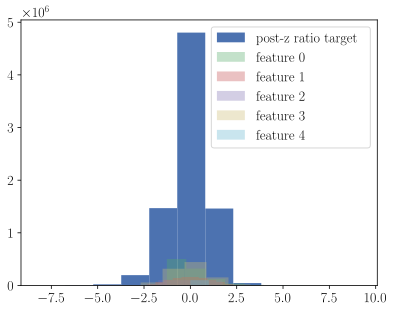

In [192]:
plt.hist(valid_t_ratio, label='post-z ratio target');
for i in range(NFEATURES):
    plt.hist(valid_x[:,i], label =f"feature {i}", alpha=0.35)
plt.legend();plt.show()

0    0.479708
1    0.453907
2    0.453907
3    0.453907
4    0.099661
dtype: float64
predicted ratio shape:  (1000000, 1)


/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


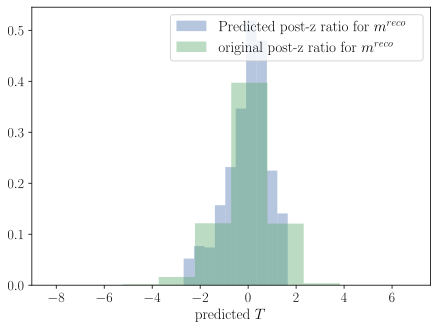

In [193]:
def simple_eval(model):
    model.eval()
    valid_x_tensor=torch.from_numpy(valid_x).float()
    pred = IQN(valid_x_tensor)
    p = pred.detach().numpy()
    fig, ax = plt.subplots(1,1)
    label=FIELDS[target]['ylabel']
    ax.hist(p, label=f'Predicted post-z ratio for {label}', alpha=0.4, density=True)
    orig_ratio = z(T('m', scaled_df=train_data_m))
    print(orig_ratio[:5])
    ax.hist(orig_ratio, label = f'original post-z ratio for {label}', alpha=0.4,density=True)
    ax.grid()
    set_axes(ax, xlabel='predicted $T$')
    print('predicted ratio shape: ', p.shape)
    return p
    
p = simple_eval(IQN)
plt.show()

In [194]:
# IQN.eval()
# valid_x_tensor=torch.from_numpy(valid_x).float()
# pred = IQN(valid_x_tensor)
# p = pred.detach().numpy()
# plt.hist(p, label='predicted $T$ ratio');plt.legend();plt.show()

$$
        f_{\text{IQN}} (\mathcal{O}) =  z \left( \frac{\mathbb{L} (\mathcal{O}^{\text{reco}}) +10 }{\mathbb{L}(\mathcal{O}^{\text{gen}}) +10} \right),
$$


So, to de-scale, (for our observable $\mathcal{O}=m$ ),

$$
    m^{\text{predicted}} = \mathbb{L}^{-1} \left[ z^{-1} (f_{\text{IQN}} ) \left[ \mathbb{L} (m^\text{gen})+10 \right] -10 \right]
$$

Note that $z^{-1} (f_{\text{IQN}} )$ should use the mean and std of the ratio thing for the target 

$$z^{-1} (f_{\text{IQN}} ) = z^{-1}\left( y_{pred}, \text{mean}=\text{mean}(\mathbb{T}(\text{target_variable})), std=std (\mathbb{T}(\text{target_variable} ) \right)$$

In [195]:
def z_inverse(xprime, mean, std):
    return xprime * std + mean

In [196]:
recom_unsc_mean=TEST_SCALE_DICT[target]['mean']
recom_unsc_std=TEST_SCALE_DICT[target]['std']
print(recom_unsc_mean,recom_unsc_std)

5.554066938043617 2.644892802850232


Get unscaled dataframe again, just to verify

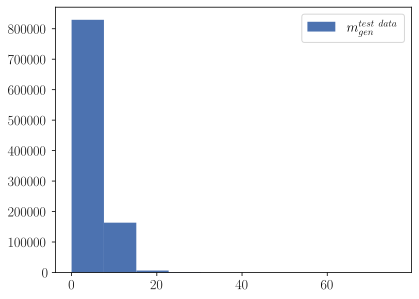

In [197]:
raw_train_data=pd.read_csv(os.path.join(DATA_DIR,'train_data_10M_2.csv'),
                      usecols=all_cols,
                      nrows=SUBSAMPLE
                      )

raw_test_data=pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'),
                      usecols=all_cols,
                     nrows=SUBSAMPLE
                     )
raw_test_data.describe()
m_reco = raw_test_data['RecoDatam']
m_gen = raw_test_data['genDatam']
plt.hist(m_reco,label=r'$m_{gen}^{test \ data}$');plt.legend();plt.show()



Apply the descaling formula for our observable

$$
    m^{\text{predicted}} = \mathbb{L}^{-1} \left[ z^{-1} (f_{\text{IQN}} ) \left[ \mathbb{L} (m^\text{gen})+10 \right] -10 \right]
$$

* First, calculate $z^{-1} (f_{\text{IQN}} )$

In [198]:
print(valid_t_ratio.shape, valid_t_ratio[:5])

(8000000,) [0.47970804 0.45390654 0.45390654 0.45390654 0.09966065]


In [199]:
orig_ratio = T('m', scaled_df=train_data_m)
orig_ratio[:5]

0    0.995290
1    0.994742
2    0.994742
3    0.994742
4    0.987216
dtype: float64

In [200]:
z_inv_f =z_inverse(xprime=p, mean=np.mean(orig_ratio), std=np.std(orig_ratio))
z_inv_f[:5]

array([[1.010673  ],
       [1.0099984 ],
       [0.98119617],
       [0.97980946],
       [0.98448396]], dtype=float32)

* Now 

$$\mathbb{L}(\mathcal{O^{\text{gen}}}) = \mathbb{L} (m^{\text{gen}})$$


In [201]:
L_obs = L(orig_observable=m_gen, label='m')
L_obs[:5]

array([2.07104388, 2.07104388, 2.24205984, 2.28661525, 1.97173801])

In [202]:
print(L_obs.shape, z_inv_f.shape)

(1000000,) (1000000, 1)


In [203]:
z_inv_f = z_inv_f.flatten();print(z_inv_f.shape)

(1000000,)


* "factor" $ = z^{-1} (f_{\text{IQN}} ) \left[ \mathbb{L} (m^\text{gen})+10 \right] -10 $

In [204]:
factor = (z_inv_f * (L_obs  + 10) )-10
factor[:5]

array([2.19987869, 2.1917355 , 2.01186217, 2.03854189, 1.78598401])

In [205]:
m_pred = L_inverse(L_observable=factor, label='m')
# pT_pred=get_finite(pT_pred)

In [206]:
m_pred

array([7.02391872, 6.95073361, 5.47722825, ..., 2.41978714, 3.13010808,
       5.48240938])

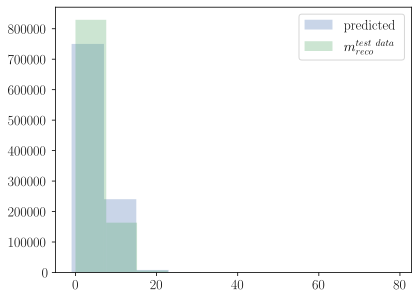

In [207]:
plt.hist(m_pred.flatten(),label='predicted',alpha=0.3);
plt.hist(m_reco,label=r'$m_{reco}^{test \ data}$',alpha=0.3);

plt.legend();plt.show()

------------------
### Paper plotting

In [208]:
range_=[0,25]
bins=50
data=raw_train_data
YLIM=(0.8,1.2)
data = data[['RecoDatapT','RecoDataeta','RecoDataphi','RecoDatam']]
data.columns = ['realpT','realeta','realphi','realm']
REAL_DIST=data['realm']
norm_data=data.shape[0]
AUTOREGRESSIVE_DIST = m_pred
norm_IQN=AUTOREGRESSIVE_DIST.shape[0]
norm_autoregressive=AUTOREGRESSIVE_DIST.shape[0]
norm_IQN=norm_autoregressive
print('norm_data',norm_data,'\nnorm IQN',norm_IQN,'\nnorm_autoregressive', norm_autoregressive)

norm_data 8000000 
norm IQN 1000000 
norm_autoregressive 1000000


In [209]:
def get_hist(label):
    """label could be "pT", "eta", "phi", "m"
    """
    predicted_label_counts, label_edges = np.histogram(JETS_DICT['Predicted_RecoData'+label]['dist'], 
    range=JETS_DICT['Predicted_RecoData'+label]['range'], bins=bins)
    real_label_counts, _ = np.histogram(JETS_DICT['Real_RecoData'+label]['dist'], 
    range=JETS_DICT['Real_RecoData'+label]['range'], bins=bins)
    label_edges = label_edges[1:]/2+label_edges[:-1]/2

    return real_label_counts, predicted_label_counts, label_edges

def get_hist_simple(label):
    predicted_label_counts, label_edges = np.histogram(m_pred , range=range_, bins=bins)
    real_label_counts, _ = np.histogram(REAL_DIST, range=range_, bins=bins)
    label_edges = label_edges[1:]/2+label_edges[:-1]/2
    return real_label_counts, predicted_label_counts, label_edges

In [210]:
real_label_counts_m, predicted_label_counts_m, label_edges_m = get_hist_simple('m')

In [211]:
def plot_one_m():
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.5*3/2.5,3.8), gridspec_kw={'height_ratios': [2,0.5]})
    ax1.step(label_edges_m, real_label_counts_m/norm_data, where="mid", color="k", linewidth=0.5)# step real_count_pt
    ax1.step(label_edges_m, predicted_label_counts_m/norm_IQN, where="mid", color="#D7301F", linewidth=0.5)# step predicted_count_pt
    ax1.scatter(label_edges_m, real_label_counts_m/norm_data, label="reco",  color="k",facecolors='none', marker="o", s=5, linewidth=0.5)
    ax1.scatter(label_edges_m,predicted_label_counts_m/norm_IQN, label="predicted sbatch 1", color="#D7301F", marker="x", s=5, linewidth=0.5)
    ax1.set_xlim(range_)
    ax1.set_ylim(0, max(predicted_label_counts_m/norm_IQN)*1.1)
    ax1.set_ylabel("counts")
    ax1.set_xticklabels([])
    ax1.legend(loc='upper right')

    ratio=(predicted_label_counts_m/norm_IQN)/(real_label_counts_m/norm_data)
    ax2.scatter(label_edges_m, ratio, color="r", marker="x", s=5, linewidth=0.5)#PREDICTED (IQN)/Reco (Data)
    ax2.scatter(label_edges_m, ratio/ratio, color="k", marker="o",facecolors="none", s=5, linewidth=0.5)
    ax2.set_xlim(range_)
    # ax2.set_xlabel(labels[3])
    ax2.set_ylabel(r"$\frac{\textnormal{predicted}}{\textnormal{reco}}$")
    ax2.set_ylim((YLIM))
    ax2.set_xlim(range_)
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.5, hspace=0.2)
    fig.subplots_adjust(wspace=0.0, hspace=0.1)
    # plt.savefig(DIR+'AUTOREGRESSIVE_m_TUNEND_MLP_OCT_18.pdf')
    #   plt.savefig('images/all_m_g2r.pdf')
    plt.show(); 
    # fig.show()

    plt.axis('off')
    plt.gca().set_position([0, 0, 1, 1])

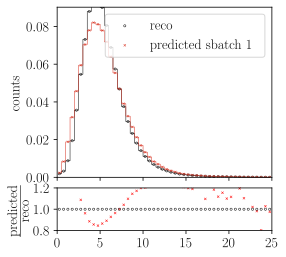

In [212]:
plot_one_m()

-------------
-------------
-------------


In [137]:
if target== 'RecoDatapT':
    label= '$p_T$ [GeV]'
    x_min, x_max = 20, 60
elif target== 'RecoDataeta':
    label = '$\eta$'
    x_min, x_max = -5.4, 5.4
elif target =='RecoDataphi':
    label='$\phi$'
    x_min, x_max = -3.4, 3.4
elif target == 'RecoDatam':
    label = ' $m$ [GeV]'
    x_min, x_max = 0, 18


    
def evaluate_model(dnn, target, src,
               fgsize=(6, 6), 
               ftsize=20,save_image=False, save_pred=False,
               show_plot=True):
    eval_data=pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'))
    ev_features=X
    #['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','tau']
    
    eval_data=eval_data[ev_features]
    
    print('EVALUATION DATA OLD INDEX\n', eval_data.head())

    

                            
    dnn.eval()
    y = dnn(eval_data)
    eval_data['RecoDatam']=y
    new_cols= ['RecoDatam'] + X
    eval_data=eval_data.reindex(columns=new_cols)
    print('EVALUATION DATA NEW INDEX\n', eval_data.head())

    eval_data.to_csv('AUTOREGRESSIVE_m_Prime.csv')


    if save_pred:
        pred_df = pd.DataFrame({T+'_predicted':y})
        pred_df.to_csv('predicted_data/dataset2/'+T+'_predicted_MLP_iter_5000000.csv')
        
    if save_image or show_plot:
        gfile ='fig_model_%s.png' % target
        xbins = 100
        xmin  = src['xmin']
        xmax  = src['xmax']
        xlabel= src['xlabel']
        xstep = (xmax - xmin)/xbins

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
        
        ax.set_xlim(xmin, xmax)
        ax.set_xlabel(xlabel, fontsize=ftsize)
        ax.set_xlabel('reco jet '+label, fontsize=ftsize)
        ax.set_ylabel(y_label_dict[target], fontsize=ftsize)

        ax.hist(train_data['RecoDatam'], 
                bins=xbins, 
                range=(xmin, xmax), 
                alpha=0.3, 
                color='blue', 
                density=True, 
                label='simulation')
        ax.hist(y, 
                bins=xbins, 
                range=(xmin, xmax), 
                alpha=0.3, 
                color='red', 
                density=True, 
                label='$y^\prime$')
        ax.grid()
        ax.legend()
        
        
        if save_image:
            plt.savefig('images/'+T+'IQN_Consecutive_'+N+'.png')
            print('images/'+T+'IQN_Consecutive_'+N+'.png')
        if show_plot:
            plt.tight_layout()
            plt.show()
##########
################################################CNN







def main():
    start=time.time()
    print('estimating mass\n')
    model =  utils.RegularizedRegressionModel(nfeatures=train_x.shape[1], ntargets=1,nlayers=n_layers, hidden_size=n_hidden)
    traces = ([], [], [], [])
    dnn = run(model, scalers, target, train_x, train_t, valid_x, valid_t, traces)
    evaluate_model( dnn, target, source)



if __name__ == "__main__":
    main()



estimating mass



NameError: name 'scalers' is not defined

# Plot predicted vs real reco (in our paper's format)

# Train $p_T$ using saved variables above

Evaluate $p_T$ and save predicted distribution

Plot reco $p_T$ and  predicted reco $p_T$ marginal densities

In [155]:
# show_jupyter_image('screenshot.png')

<!-- > I guess it works now -->

commented new ideas below

<!-- ### Ideas for a future paper

me and Harrison would like to use this method for on-the-fly stochastic folding of events in MC generators (potentially even including CMSSW formats like [nanoaod](https://github.com/cms-nanoAOD/nanoAOD-tools), such as in Madminer (but using IQN as opposed to Delphes for detector simulation) for any observable. This also beings the possibility of using LFI methods for much better inference on models (such as SMEFT) using any observable post-detector simulation. If you're interested in helping out on this, me and Harrison would like to do most of the code/ideas, but your occasional ideas/input would be incredibly valuable! -->